In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os
import plotly.graph_objects as go
import numpy as np
from plotly.offline import init_notebook_mode, iplot

# Define Data paths and Preprocessing

In [2]:
# Load the data
file_path = '/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/2024-06-18-all-models.csv'
run_dp_path = '/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/runs-dropout.csv'
df_main = pd.read_csv(file_path, header=0)
df_dropout = pd.read_csv(run_dp_path, header=0)
df_main.columns = df_main.columns.str.strip()  # Strip any whitespace from headers
df_dropout.columns = df_dropout.columns.str.strip()  # Strip any whitespace from headers
# Extract the run name from 'model name' in the main data
df_main['RunName'] = df_main['model name'].apply(lambda x: x.split('_')[-1])

# Merge the datasets on the extracted RunName and the Name from the dropout file
df_main = pd.merge(df_main, df_dropout, left_on='RunName', right_on='Name', how='left')

df_merged = df_main.copy()
# df_main.head()

In [3]:
df_merged = df_merged[~((df_merged['Model type'] == 'mcdropout') & (df_merged['Split'] == 'scaffold_cluster') & (df_merged['dropout'] == 0.1))]
df_merged = df_merged[~((df_merged['Model type'] == 'mcdropout') & (df_merged['Split'] == 'random') & (df_merged['dropout'] == 0.2))]

# Extracting the necessary parts for plotting and make copies to avoid SettingWithCopyWarning
df_before_calib = df_merged[df_merged['Task'].str.contains('before_calibration')].copy()
df_after_calib_iso = df_merged[df_merged['Task'].str.contains('after_calibration_with_isotonic_regression')].copy()
df_after_calib_std = df_merged[df_merged['Task'].str.contains('after_calibration_with_std_recalibrator')].copy()

# Create a unique identifier for each group
df_before_calib['Group'] = df_before_calib.apply(lambda row: f"{row['Split']}_{row['Model type']}", axis=1)  # _dropout{row['dropout']}
df_after_calib_iso['Group'] = df_after_calib_iso.apply(lambda row: f"{row['Split']}_{row['Model type']}", axis=1)  # _dropout{row['dropout']}
df_after_calib_std['Group'] = df_after_calib_std.apply(lambda row: f"{row['Split']}_{row['Model type']}", axis=1)  # _dropout{row['dropout']}


group_order = [
    "random_ensemble",
    "random_evidential",
    "random_mcdropout",
    "scaffold_cluster_ensemble",
    "scaffold_cluster_evidential",
    "scaffold_cluster_mcdropout"
]

In [4]:
# SEPARATE SPECIAL MC EXPERIMENT
mcdp_df = df_main[df_main['Model type'] == 'mcdropout'].copy()
mcdp_df['Group'] = mcdp_df.apply(lambda row: f"{row['Split']}_dropout{row['dropout']}", axis=1)

mcdp_before_calib = mcdp_df[mcdp_df['Task'].str.contains('before_calibration')].copy()
mcdp_after_calib_iso = mcdp_df[mcdp_df['Task'].str.contains('after_calibration_with_isotonic_regression')].copy()
mcdp_after_calib_std = mcdp_df[mcdp_df['Task'].str.contains('after_calibration_with_std_recalibrator')].copy()

mc_group_order = [
    "random_dropout0.1",
    "random_dropout0.2",
    "scaffold_cluster_dropout0.1",
    "scaffold_cluster_dropout0.2"
]

# Helper plotting functions

In [5]:
# HELPER FUNCTIONS FOR PLOTTING #
def save_plot(fig, save_dir, plot_name):
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, f"{plot_name}.png"))
        fig.savefig(os.path.join(save_dir, f"{plot_name}.svg"))
        
# Function to handle inf values
def handle_inf_values(df):
    df = df.replace([float('inf'), -float('inf')], float('nan'))
    return df


# Pair plot for visualizing relationships
def plot_pairplot(df, title, metrics, save_dir=None):
    df = handle_inf_values(df)
    sns.pairplot(df, hue='Group', vars=metrics, palette='Set2', plot_kws={'alpha': 0.7})
    plt.suptitle(title, y=1.02)
    plot_name = f"pairplot_{title.replace(' ', '_')}"
    save_plot(plt.gcf(), save_dir, plot_name)
    plt.show()
# 

# Function to plot metrics with split type grouping
def plot_metrics(df, title, metrics, plot_type='boxplot', save_dir=None, group_order=group_order):
    df = handle_inf_values(df)
    melted_df = df.melt(id_vars=['Group'], value_vars=metrics, var_name='Metric', value_name='Value')
    plt.figure(figsize=(14, 7))
    if plot_type == 'boxplot':
        sns.boxplot(data=melted_df, x='Metric', y='Value', hue='Group', palette="Set2", order=metrics, hue_order=group_order)
    elif plot_type == 'violin':
        sns.violinplot(data=melted_df, x='Metric', y='Value', hue='Group', inner="quart", palette="Set2", order=metrics, hue_order=group_order)
    elif plot_type == 'swarm':
        sns.swarmplot(data=melted_df, x='Metric', y='Value', hue='Group', palette="Set2", dodge=True, order=metrics, hue_order=group_order)
    elif plot_type == 'bar':
        sns.barplot(data=melted_df, x='Metric', y='Value', hue='Group', palette="Set2", hue_order=group_order)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plot_name = f"{plot_type}_{title.replace(' ', '_')}"
    save_plot(plt.gcf(), save_dir, plot_name)
    plt.show()

# Function to plot line metrics
def plot_line_metrics(df, title, metrics, save_dir=None, group_order=group_order):
    df = handle_inf_values(df)
    plt.figure(figsize=(14, 7))
    for metric in metrics:
        sns.lineplot(data=df, x='RunName', y=metric, hue='Group', marker='o', palette="Set2", hue_order=group_order)
        plt.title(f'{title} - {metric}')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

        plot_name = f"line_{title.replace(' ', '_')}_{metric}"
        save_plot(plt.gcf(), save_dir, plot_name)

# Function to plot histograms for metrics
def plot_histogram_metrics(df, title, metrics, save_dir=None, group_order=group_order):
    df = handle_inf_values(df)
    plt.figure(figsize=(14, 7))
    for metric in metrics:
        sns.histplot(data=df, x=metric, hue='Group', kde=True, palette="Set2", element="step", hue_order=group_order, fill=True, alpha=0.7)
        plt.title(f'{title} - {metric}')
        plt.show()

        plot_name = f"histogram_{title.replace(' ', '_')}_{metric}"
        save_plot(plt.gcf(), save_dir, plot_name)

# Function to plot scatter plots for metrics
# def plot_scatter_metrics(df, title, metrics, save_dir=None):
#     df = handle_inf_values(df)
#     plt.figure(figsize=(14, 7))
#     for i in range(len(metrics)):
#         for j in range(i + 1, len(metrics)):
#             sns.scatterplot(data=df, x=metrics[i], y=metrics[j], hue='Group', palette="Set2", alpha=0.7, s=100, hue_order=group_order)
#             plt.title(f'{title} - {metrics[i]} vs {metrics[j]}')
#             plt.show()
# 
#             plot_name = f"scatter_{title.replace(' ', '_')}_{metrics[i]}_vs_{metrics[j]}"
#             save_plot(plt.gcf(), save_dir, plot_name)

# Function to plot pairwise scatter plots for metrics
def plot_pairwise_scatter_metrics(df, title, metrics, save_dir=None, group_order=group_order):
    df = handle_inf_values(df)
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, num_metrics, figsize=(15, 15))
    
    for i, j in itertools.product(range(num_metrics), range(num_metrics)):
        if i != j:  # Only plot the lower triangle
            ax = sns.scatterplot(data=df, x=metrics[j], y=metrics[i], hue='Group', palette="Set2", hue_order=group_order, ax=axes[i, j], legend=False if not (i == 1 and j == 0) else 'brief')
            if i == 1 and j == 0:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend().remove()
        else:
            axes[i, j].set_visible(False)  # Hide the diagonal and upper triangle subplots

        if j == 0 and i > 0:
            axes[i, j].set_ylabel(metrics[i])
        else:
            axes[i, j].set_ylabel('')
        
        if i == num_metrics - 1:
            axes[i, j].set_xlabel(metrics[j])
        else:
            axes[i, j].set_xlabel('')
    
    # Add a single legend
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))
    fig.suptitle(title, y=1.02)
    fig.subplots_adjust(top=0.95, wspace=0.4, hspace=0.4)
    plot_name = f"pairwise_scatter_{title.replace(' ', '_')}"
    save_plot(fig, save_dir, plot_name)
    plt.show()




In [6]:
# Function to plot metrics with split type grouping
def plot_metrics(df, title, metrics, plot_type='boxplot', save_dir=None, group_order=group_order):
    df = handle_inf_values(df)
    melted_df = df.melt(id_vars=['Group'], value_vars=metrics, var_name='Metric', value_name='Value')
    plt.figure(figsize=(14, 7))
    if plot_type == 'boxplot':
        sns.boxplot(data=melted_df, x='Metric', y='Value', hue='Group', palette="Set2", order=metrics, hue_order=group_order)
    elif plot_type == 'violin':
        sns.violinplot(data=melted_df, x='Metric', y='Value', hue='Model type', inner="quart", palette="Set2", order=metrics, hue_order=group_order)
    elif plot_type == 'swarm':
        sns.swarmplot(data=melted_df, x='Metric', y='Value', hue='Group', palette="Set2", dodge=True, order=metrics, hue_order=group_order)
    elif plot_type == 'bar':
        sns.barplot(data=melted_df, x='Metric', y='Value', hue='Model type', style='Split', palette="Set2")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plot_name = f"{plot_type}_{title.replace(' ', '_')}"
    save_plot(plt.gcf(), save_dir, plot_name)
    plt.show()

In [7]:
df_test = df_before_calib.copy()
metrics = ['RMSE']

In [8]:
melted_df = df_test.melt(id_vars=['Group'], value_vars=metrics, var_name='Metric', value_name='Value')
print(melted_df.shape)

melted_df = df_test.melt(id_vars=['Group', 'Model type', 'Split'], value_vars=metrics, var_name='Metric', value_name='Value')
melted_df.shape

(60, 3)


(60, 5)

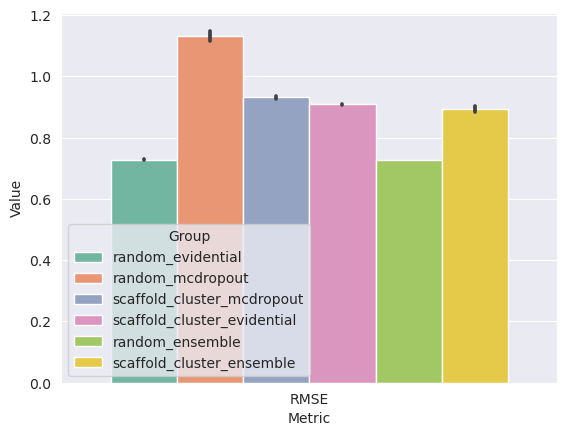

In [9]:
ax = sns.barplot(data=melted_df, x='Metric', y='Value', hue='Group', color='Model type', palette="Set2")

AttributeError: Line2D.set() got an unexpected keyword argument 'hatch'

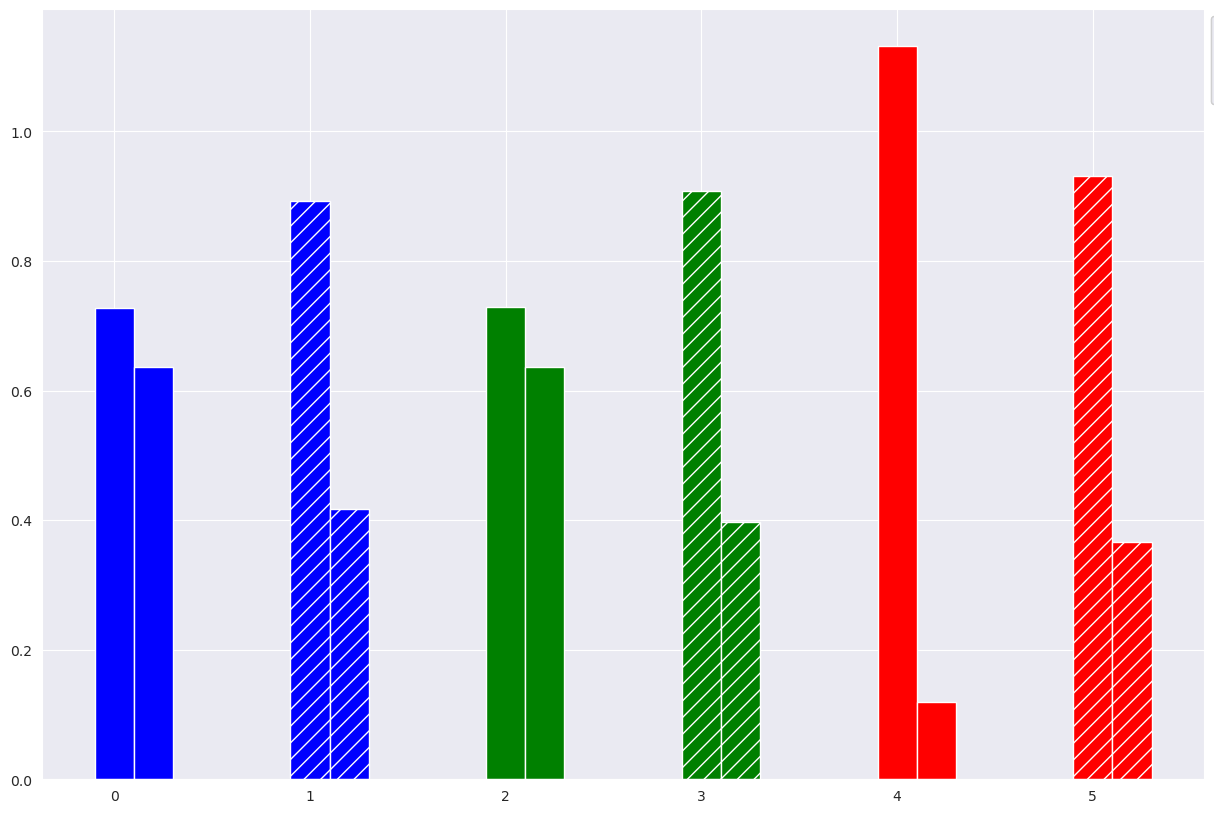

In [12]:

# Define a function to create the bar plot
def create_grouped_bar_plot(df, metrics):
    model_types = df['Model type'].unique()
    splits = df['Split'].unique()
    
    bar_width = 0.2
    colors = {
        'ensemble': 'blue',
        'mcdropout': 'red',
        'evidential': 'green'
    }
    textures = {
        'random': '',
        'scaffold_cluster': '//'
    }
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Create bar positions
    num_metrics = len(metrics)
    num_groups = len(df.groupby(['Model type', 'Split']))
    index = np.arange(num_groups)
    positions = [index + i * bar_width for i in range(num_metrics)]
    
    # Plot each metric
    for i, metric in enumerate(metrics):
        values = []
        colors_list = []
        for (model_type, split), group in df.groupby(['Model type', 'Split']):
            values.append(group[metric].mean())
            color = colors.get(model_type, 'gray')
            texture = textures.get(split, '')
            colors_list.append((color, texture))
        
        for j, (value, (color, texture)) in enumerate(zip(values, colors_list)):
            ax.bar(positions[i][j], value, bar_width, color=color, hatch=texture, label=f'{model_type}, {split}' if i == 0 else "")
    
    # Adding legend for colors (model types)
    model_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors.values()]
    model_labels = colors.keys()
    legend1 = plt.legend(model_handles, model_labels, title="Model Type", loc='upper left', bbox_to_anchor=(1, 1))
    ax.add_artist(legend1)
    
    # Adding legend for textures (splits)
    split_handles = [plt.Line2D([0], [0], color='black', lw=4, linestyle='-', hatch=texture) for texture in textures.values()]
    split_labels = ['stratified' if split == 'random' else split for split in splits]
    plt.legend(split_handles, split_labels, title="Split", loc='upper left', bbox_to_anchor=(1, 0.8))
    
    # Set labels and title
    ax.set_xlabel('Model Type and Split')
    ax.set_ylabel('Value')
    ax.set_title('Model Performance Metrics')
    ax.set_xticks(index + bar_width * (num_metrics - 1) / 2)
    ax.set_xticklabels([f'{model_type}, {split}' for model_type, split in df.groupby(['Model type', 'Split']).groups.keys()], rotation=45, ha='right')
    
    plt.show()

metrics_to_show = ['RMSE', 'R2']  # Specify the metrics you want to plot
create_grouped_bar_plot(df_test, metrics_to_show)

In [27]:
# Initialize Plotly's offline mode
init_notebook_mode(connected=True)

# Step 2: Prepare the data
def prepare_data(df, metrics):
    grouped = df.groupby(['Model type', 'Split'])
    data = []
    
    for (model_type, split), group in grouped:
        means = group[metrics].mean()
        std_errors = group[metrics].sem()
        data.append((model_type, split, means, std_errors))
    
    return data

# Step 3: Create the bar plot
def create_bar_plot(data, metrics):
    fig = go.Figure()

    model_colors = {
        'ensemble': 'green',
        'mcdropout': 'red',
        'evidential': 'blue'
    }
    
    split_textures = {
        'random': '',
        'scaffold_cluster': "/"
    }
    
    for metric in metrics:
        for (model_type, split, means, std_errors) in data:
            fig.add_trace(go.Bar(
                x=[metric],
                y=[means[metric]],
                name=model_type,
                error_y=dict(type='data', array=[std_errors[metric]]),
                marker=dict(color=model_colors[model_type], pattern_shape=split_textures[split]),
                showlegend=False
            ))

    # Add legend for splits
    for split, texture in split_textures.items():
        fig.add_trace(go.Bar(
            x=[None],
            y=[None],
            name=f'Split: {split}',
            marker=dict(color='white', pattern_shape=texture),
            showlegend=True,
            # marker_pattern_shape_texture={'pattern_shape': texture}
        ))

    # Add legend for model types
    for model_type, color in model_colors.items():
        fig.add_trace(go.Bar(
            x=[None],
            y=[None],
            name=f'Model: {model_type}',
            # name=model_type,
            marker=dict(color=color),
            showlegend=True
        ))

    fig.update_layout(
        barmode='group',
        title='Model Performance Comparison',
        xaxis_title='Metrics',
        yaxis_title='Values',
        legend_title='Legend'
    )
    # Use iplot instead of fig.show()
    iplot(fig)
    # fig.show()
    # plt.show()

# Step 4: Define the list of metrics to show
metrics = ['RMSE', 'R2']  # add other metrics as needed

# print(df_test['Model type'].unique())
# Prepare the data
data = prepare_data(df_test, metrics)

# Create the bar plot
create_bar_plot(data, metrics)

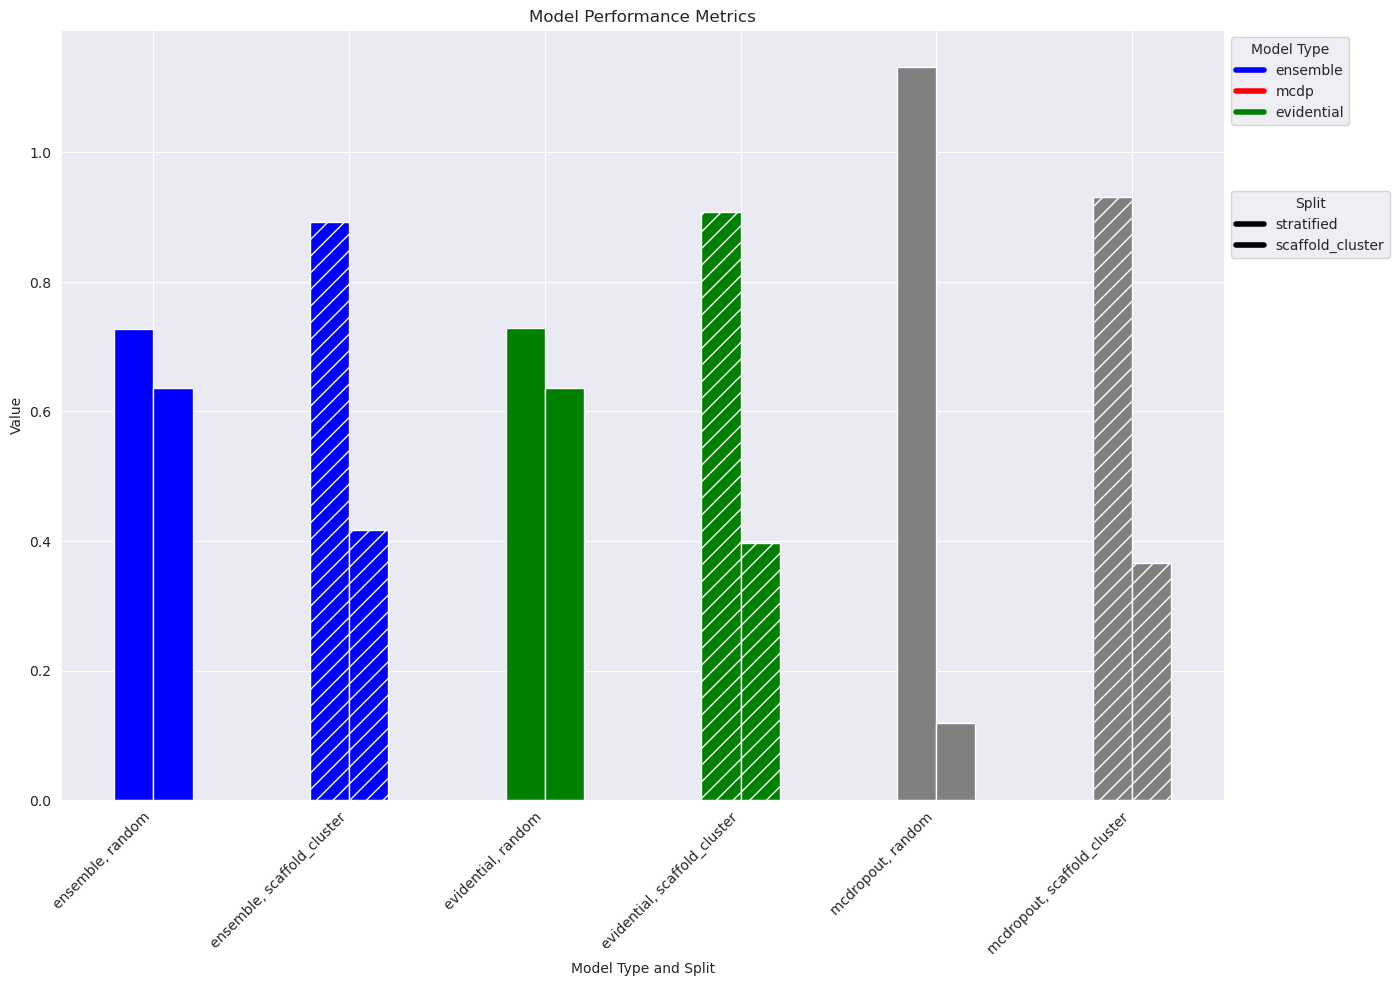

In [28]:
# Define a function to create the bar plot
def create_grouped_bar_plot(df, metrics):
    model_types = df['Model type'].unique()
    splits = df['Split'].unique()
    
    bar_width = 0.2
    colors = {
        'ensemble': 'blue',
        'mcdp': 'red',
        'evidential': 'green'
    }
    textures = {
        'random': '',
        'scaffold_cluster': '//'
    }
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Create bar positions
    num_metrics = len(metrics)
    num_groups = len(df.groupby(['Model type', 'Split']))
    index = np.arange(num_groups)
    positions = [index + i * bar_width for i in range(num_metrics)]
    
    # Plot each metric
    for i, metric in enumerate(metrics):
        values = []
        colors_list = []
        for (model_type, split), group in df.groupby(['Model type', 'Split']):
            values.append(group[metric].mean())
            color = colors.get(model_type, 'gray')
            texture = textures.get(split, '')
            colors_list.append((color, texture))
        
        for j, (value, (color, texture)) in enumerate(zip(values, colors_list)):
            ax.bar(positions[i][j], value, bar_width, color=color, hatch=texture, label=f'{model_type}, {split}' if i == 0 else "")
    
    # Adding legend for colors (model types)
    model_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors.values()]
    model_labels = colors.keys()
    legend1 = plt.legend(model_handles, model_labels, title="Model Type", loc='upper left', bbox_to_anchor=(1, 1))
    ax.add_artist(legend1)
    
    # Adding legend for textures (splits)
    split_handles = [plt.Line2D([0], [0], color='black', lw=4, linestyle='-', label='stratified' if split == 'random' else split) for split in textures.keys()]
    split_labels = ['stratified' if split == 'random' else split for split in textures.keys()]
    plt.legend(split_handles, split_labels, title="Split", loc='upper left', bbox_to_anchor=(1, 0.8))
    
    # Set labels and title
    ax.set_xlabel('Model Type and Split')
    ax.set_ylabel('Value')
    ax.set_title('Model Performance Metrics')
    ax.set_xticks(index + bar_width * (num_metrics - 1) / 2)
    ax.set_xticklabels([f'{model_type}, {split}' for model_type, split in df.groupby(['Model type', 'Split']).groups.keys()], rotation=45, ha='right')
    
    plt.show()

# Example usage
metrics_to_show = ['RMSE', 'R2']  # Specify the metrics you want to plot
create_grouped_bar_plot(df_test, metrics_to_show)

Rectangle(xy=(-0.4, 0), width=0.133333, height=0.727491, angle=0) random_evidential
random evidential
skyblue ....
Rectangle(xy=(-0.266667, 0), width=0.133333, height=0.72828, angle=0) random_mcdropout
random mcdropout
orange ....
Rectangle(xy=(-0.133333, 0), width=0.133333, height=1.13186, angle=0) scaffold_cluster_mcdropout
scaffold_cluster mcdropout
orange ////
Rectangle(xy=(9.71445e-17, 0), width=0.133333, height=0.892759, angle=0) scaffold_cluster_evidential
scaffold_cluster evidential
skyblue ////
Rectangle(xy=(0.133333, 0), width=0.133333, height=0.908307, angle=0) random_ensemble
random ensemble
green ....
Rectangle(xy=(0.266667, 0), width=0.133333, height=0.931549, angle=0) scaffold_cluster_ensemble
scaffold_cluster ensemble
green ////


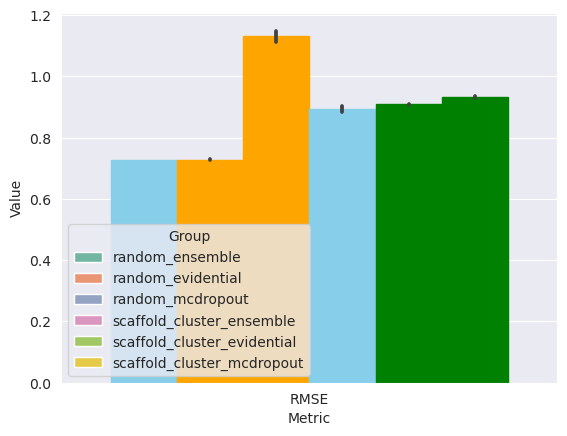

In [26]:
# Define custom colors and hatches for models and splits
model_colors = {
    'evidential': 'skyblue',
    'mcdropout': 'orange',
    'ensemble': 'green'
}

split_hatches = {
    'random': '....',
    'scaffold_cluster': '////'
}
ax = sns.barplot(data=melted_df, x='Metric', y='Value', hue='Group', color='Model type', palette="Set2", hue_order=group_order)
for patch, group in zip(ax.patches, melted_df['Group'].unique()):
    print(patch, group)
    split = 'random' if 'random' in group else 'scaffold_cluster'
    model = 'evidential' if 'evidential' in group else ('mcdropout' if 'mcdropout' in group else 'ensemble')
    hatch = split_hatches[split]
    color = model_colors[model]
    print(split, model)
    print(color, hatch)

    # patch.set_edgecolor(color)
    # patch.set_facecolor(color)
    patch.set_color(color)
    patch.set_hatch(hatch)

# MATPLOTLIB


# Accuracy Metrics

In [6]:
# some vars
acc_metrics = ['RMSE', 'R2', 'MAE', 'MDAE', 'PCC']
uct_metrics_1 = ['RMS Calibration', 'MA Calibration', 'Miscalibration Area', 'Sharpness', 'CRPS', 'Check']
uct_metrics_2 = ['NLL', 'Interval']
save_dir = '/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/2024-06-18-all-models/'
# save_dir = None

/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning

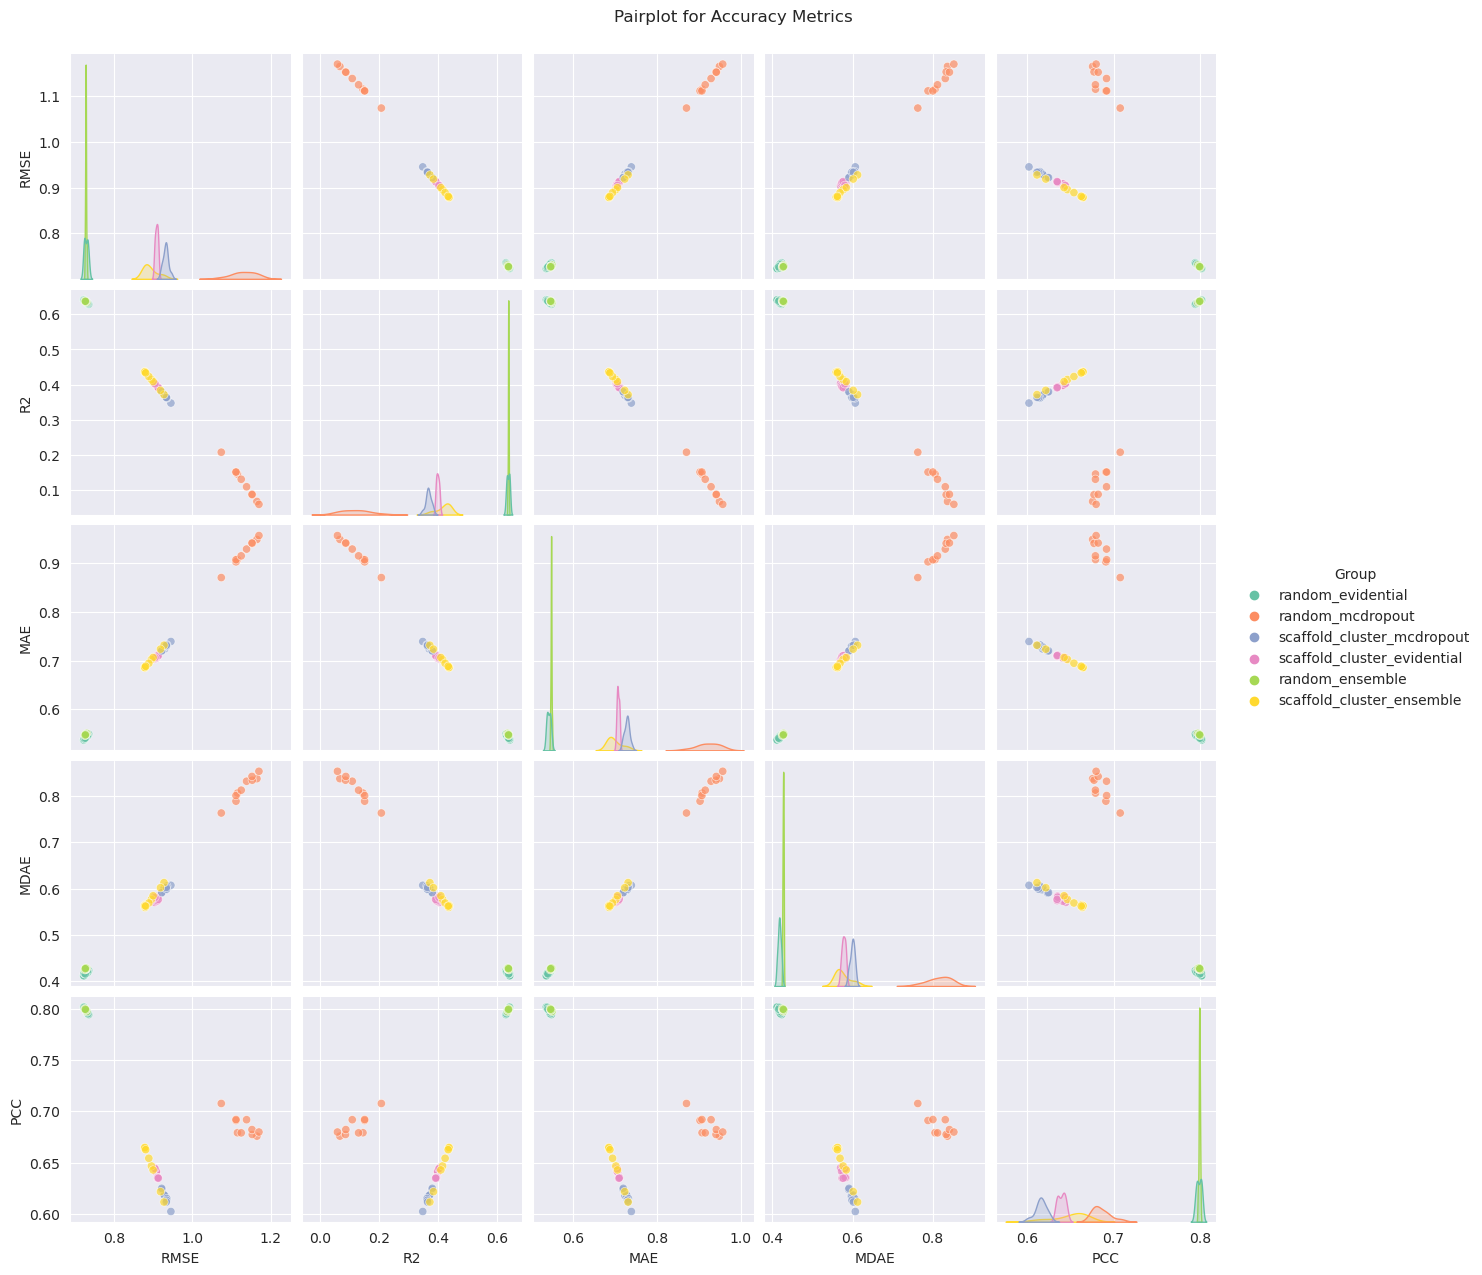

In [7]:
plot_pairplot(df_before_calib, 'Pairplot for Accuracy Metrics', acc_metrics, save_dir=save_dir)

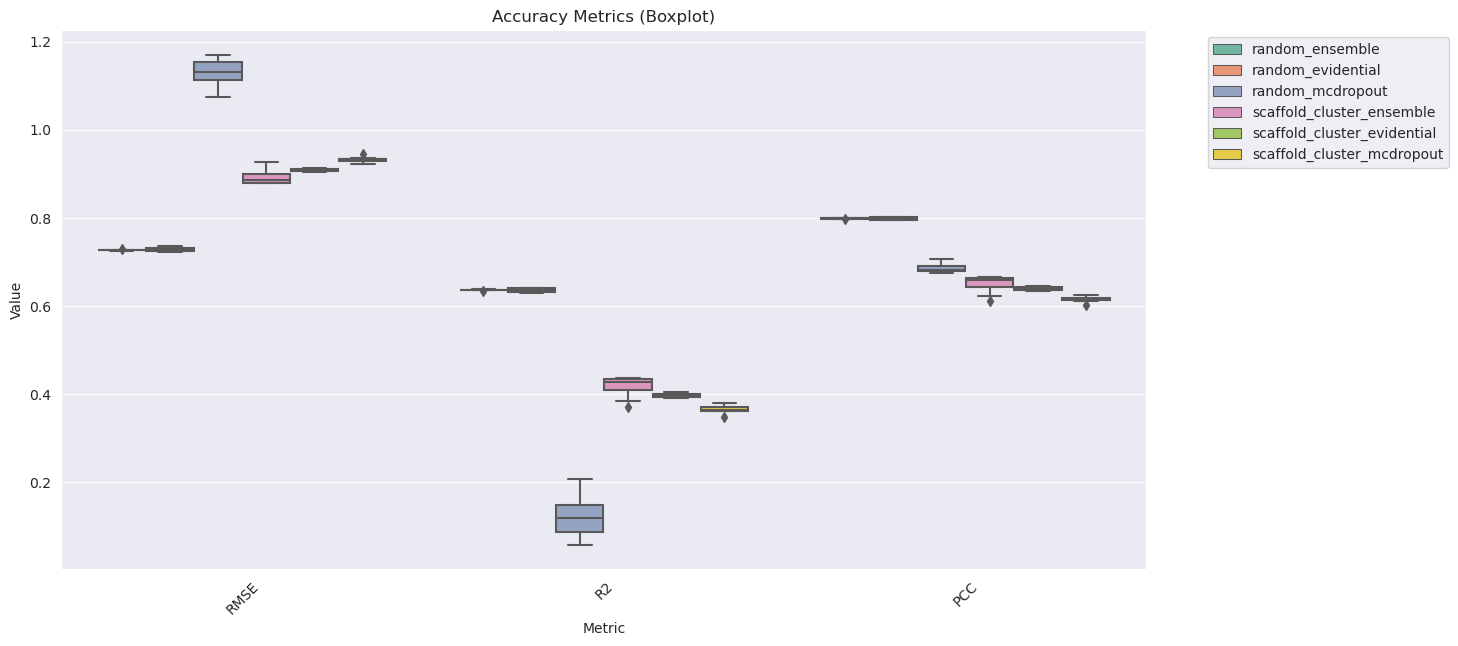

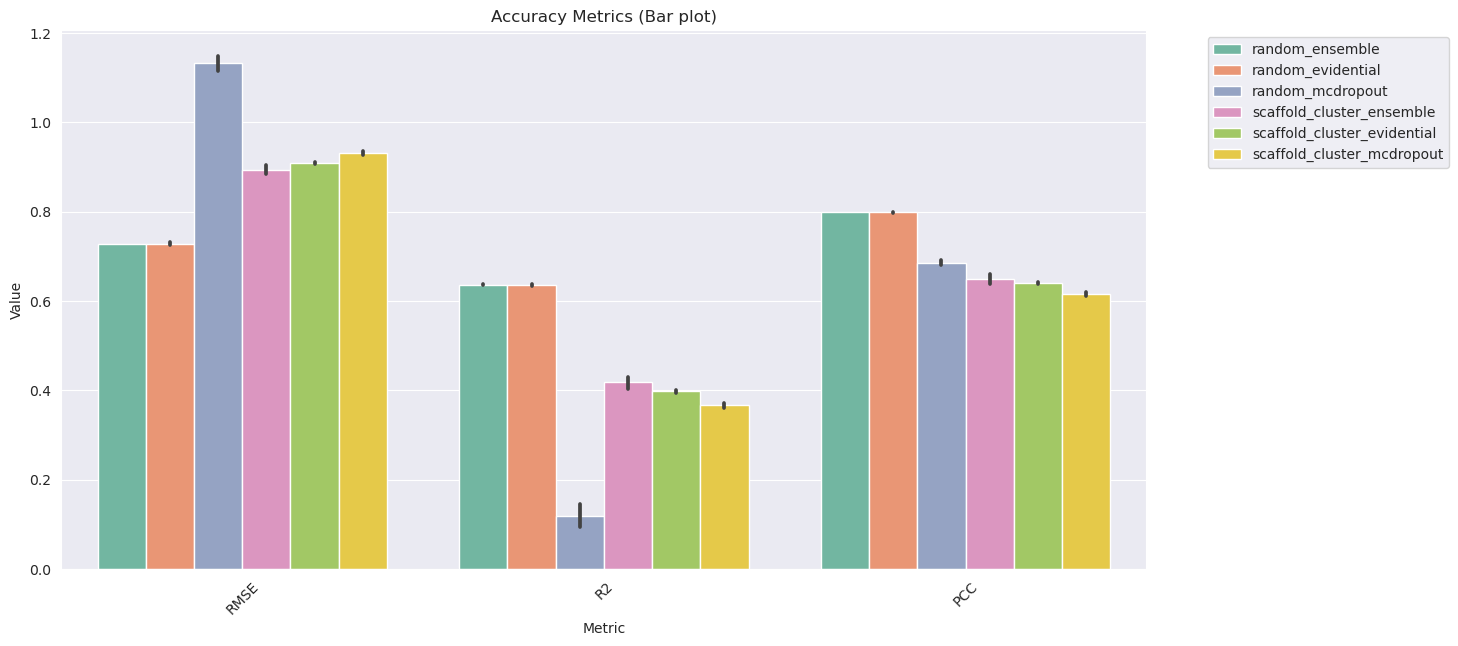

/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


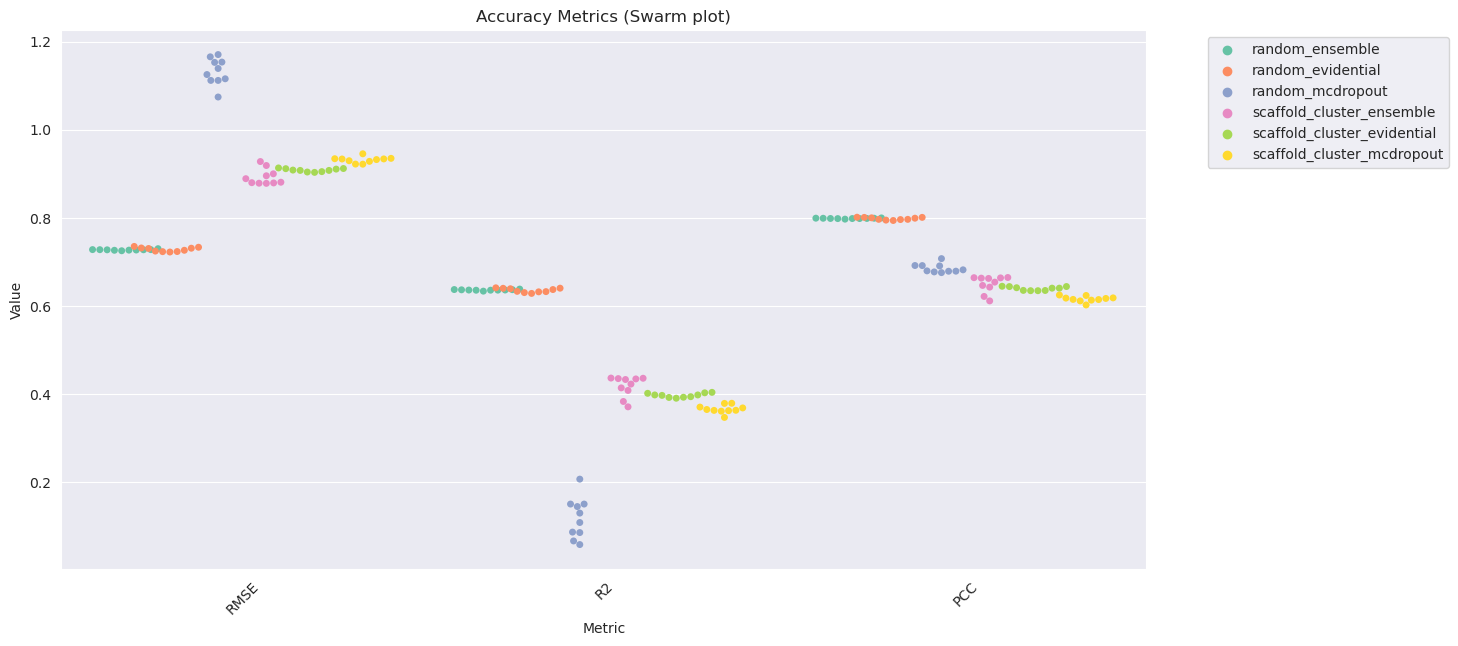

In [8]:
acc_metrics = ['RMSE', 'R2', 'PCC']
plot_metrics(df_before_calib, 'Accuracy Metrics (Boxplot)', acc_metrics, plot_type='boxplot', save_dir=save_dir)
plot_metrics(df_before_calib, 'Accuracy Metrics (Bar plot)', acc_metrics, plot_type='bar', save_dir=save_dir)
plot_metrics(df_before_calib, 'Accuracy Metrics (Swarm plot)', acc_metrics, plot_type='swarm', save_dir=save_dir)


# Uncertainty Metrics

/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning

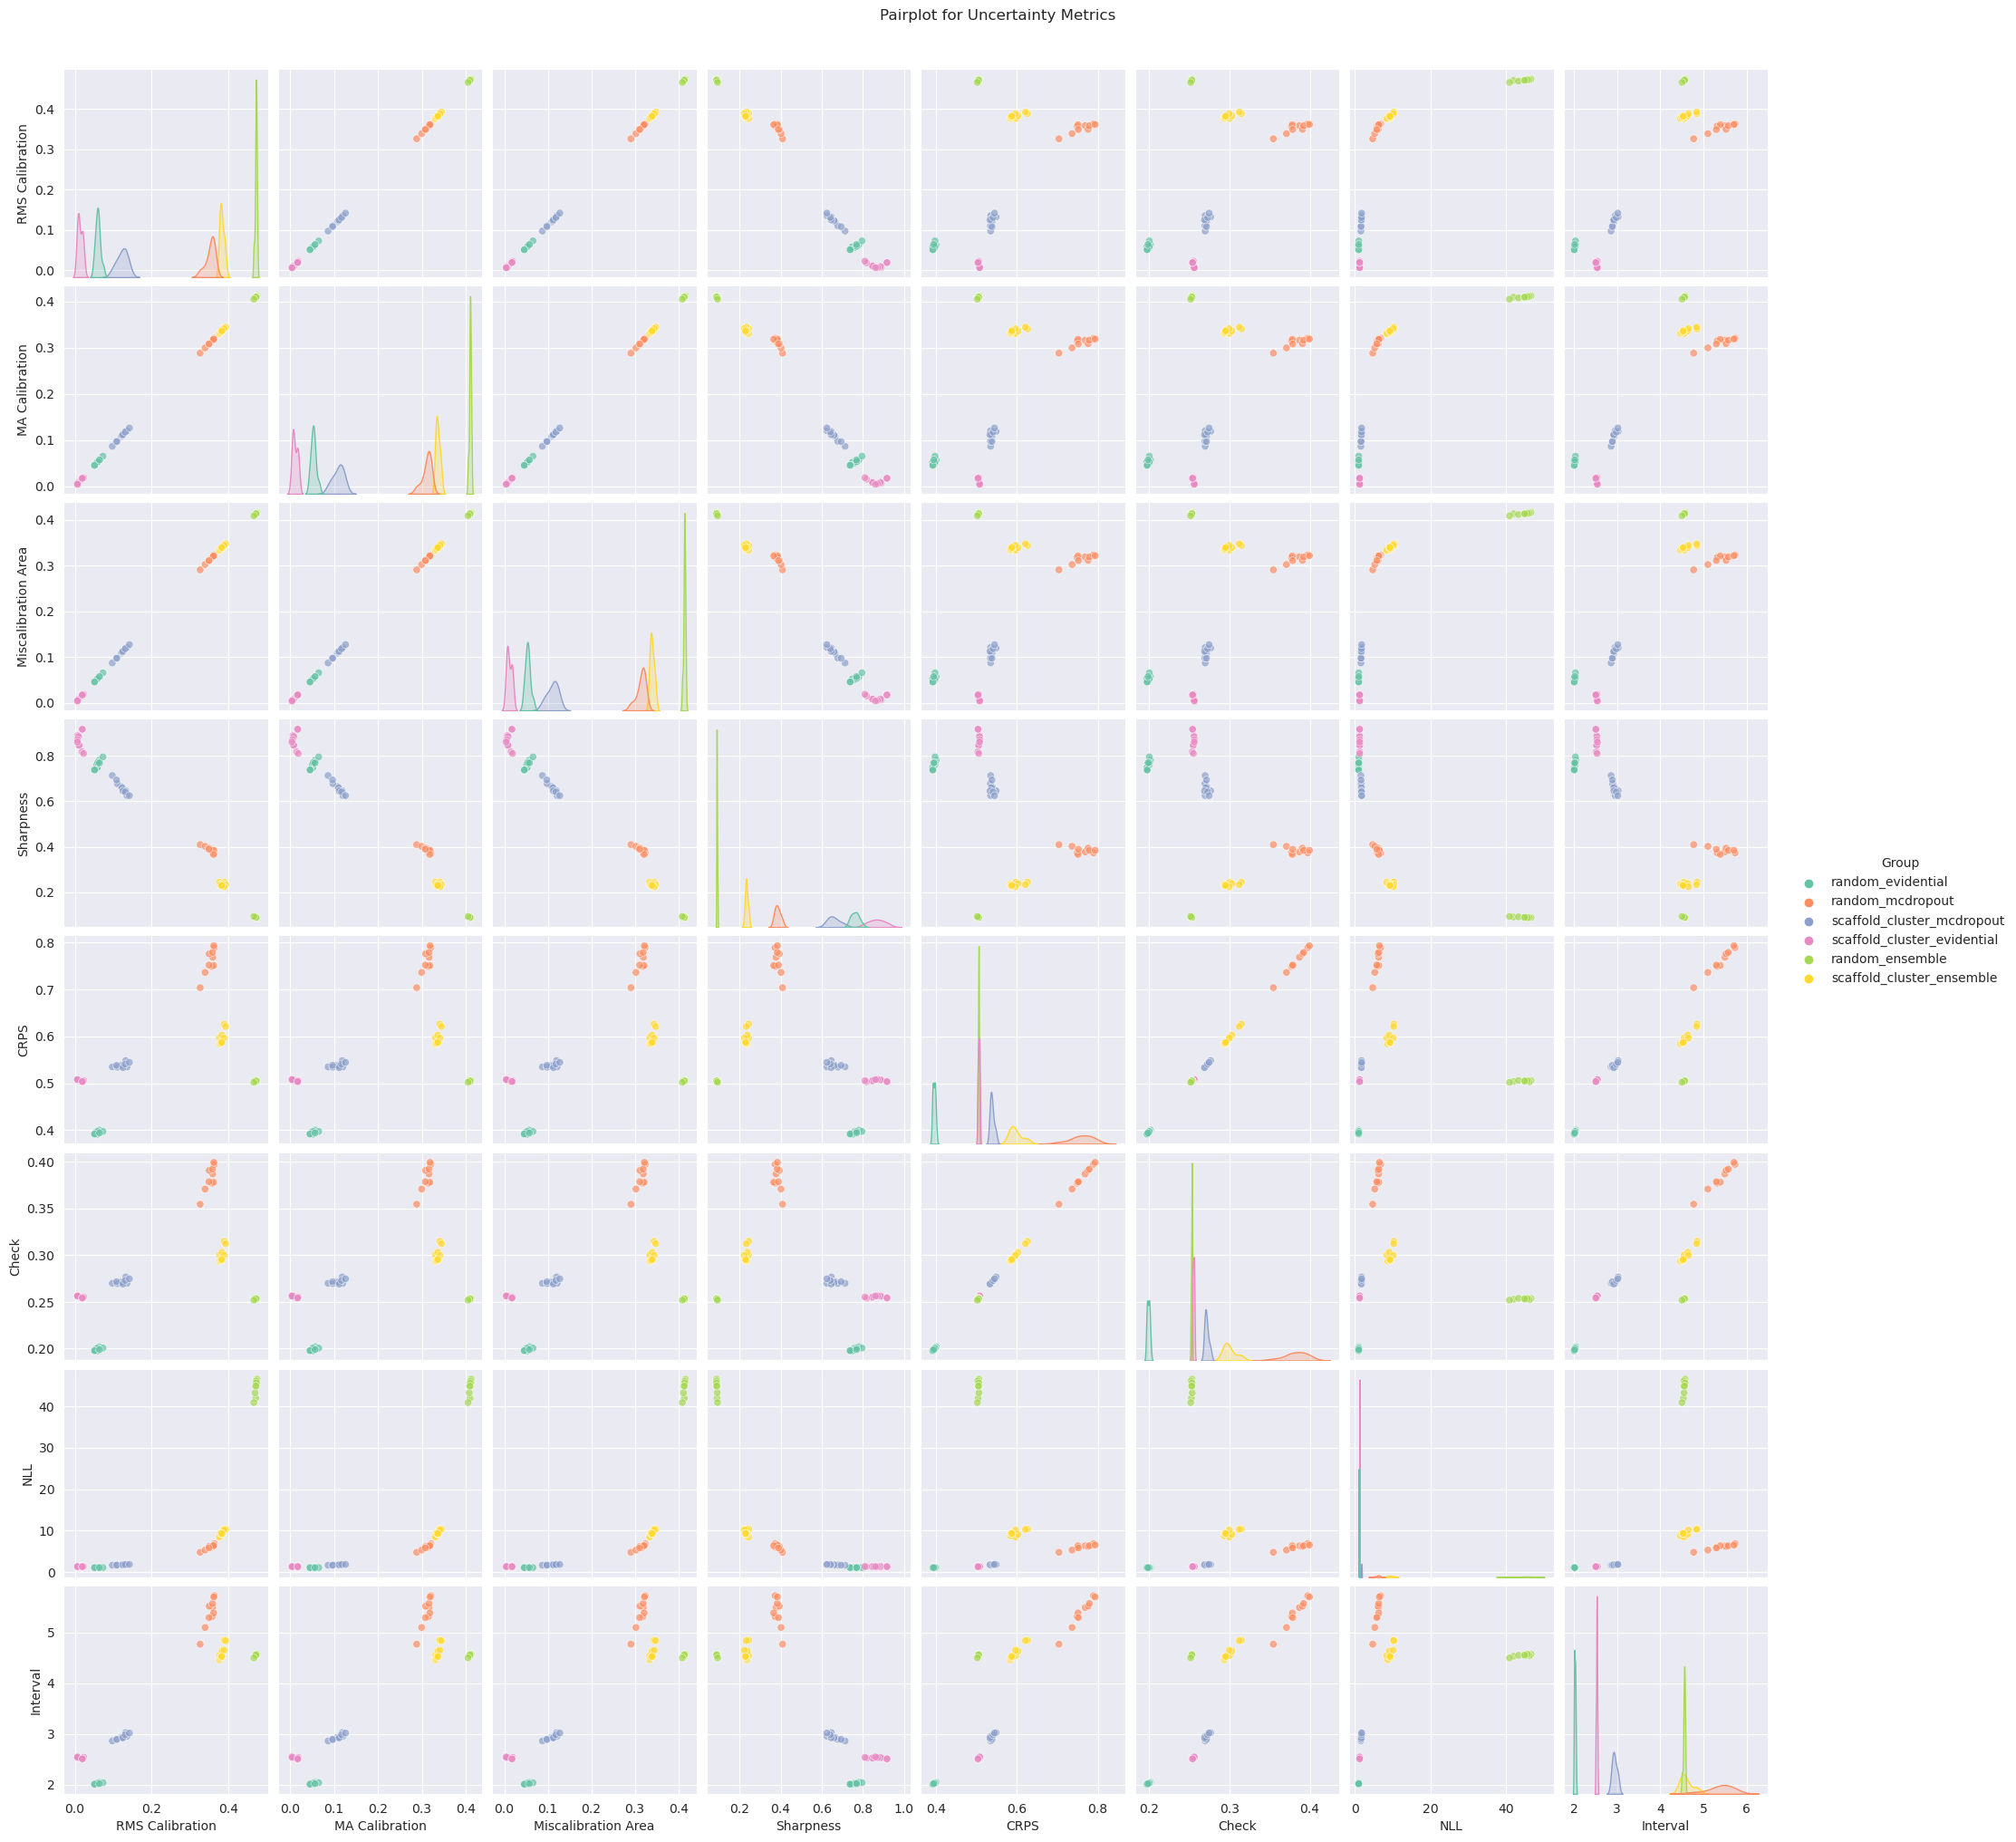

In [9]:
plot_pairplot(df_before_calib, 'Pairplot for Uncertainty Metrics', uct_metrics_1+uct_metrics_2, save_dir=save_dir)

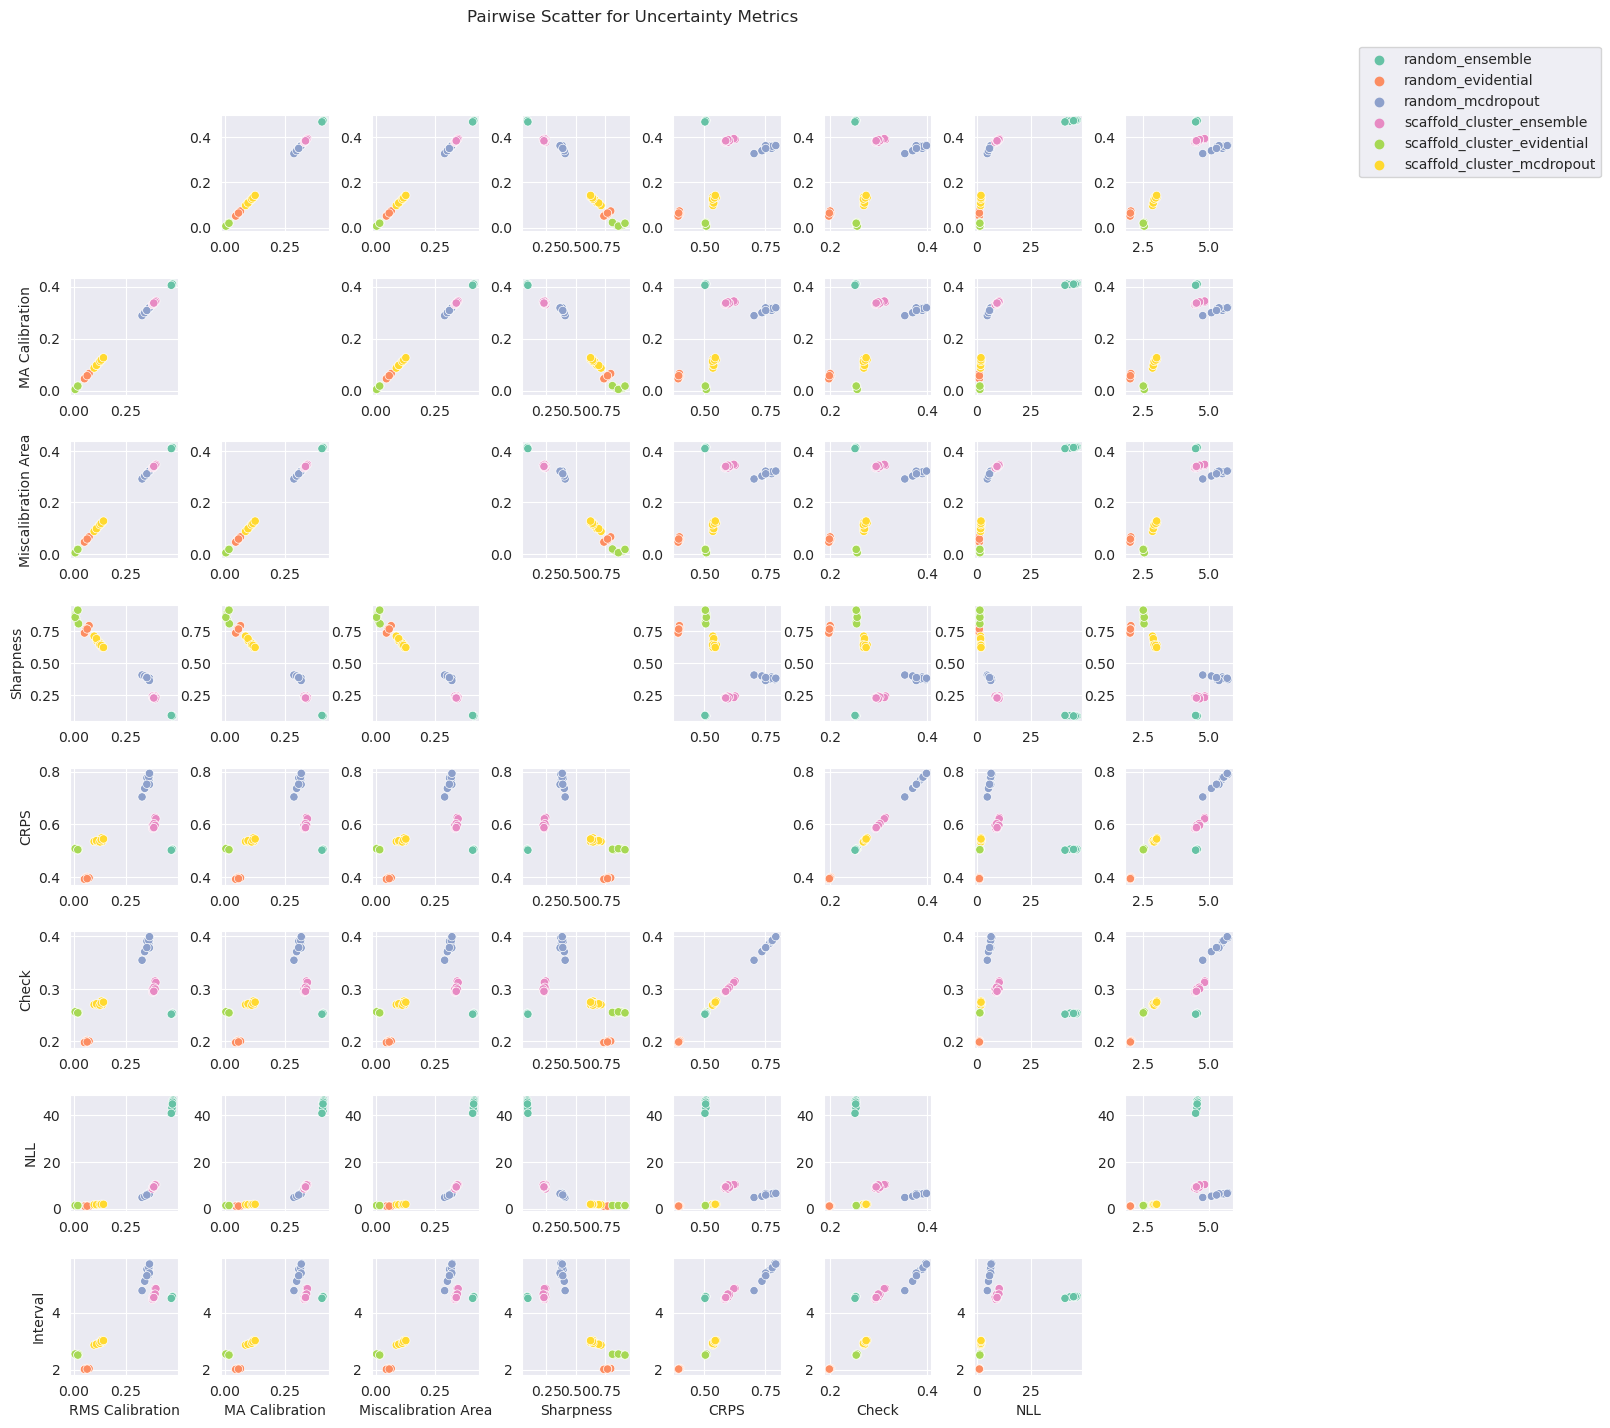

In [10]:
plot_pairwise_scatter_metrics(df_before_calib, 'Pairwise Scatter for Uncertainty Metrics', uct_metrics_1+uct_metrics_2, save_dir=save_dir)

In [9]:
uct_metrics_1 = ['Miscalibration Area', 'Sharpness', 'CRPS']
uct_metrics_2 = ['NLL', 'Interval']
uct_metrics = uct_metrics_1 + uct_metrics_2

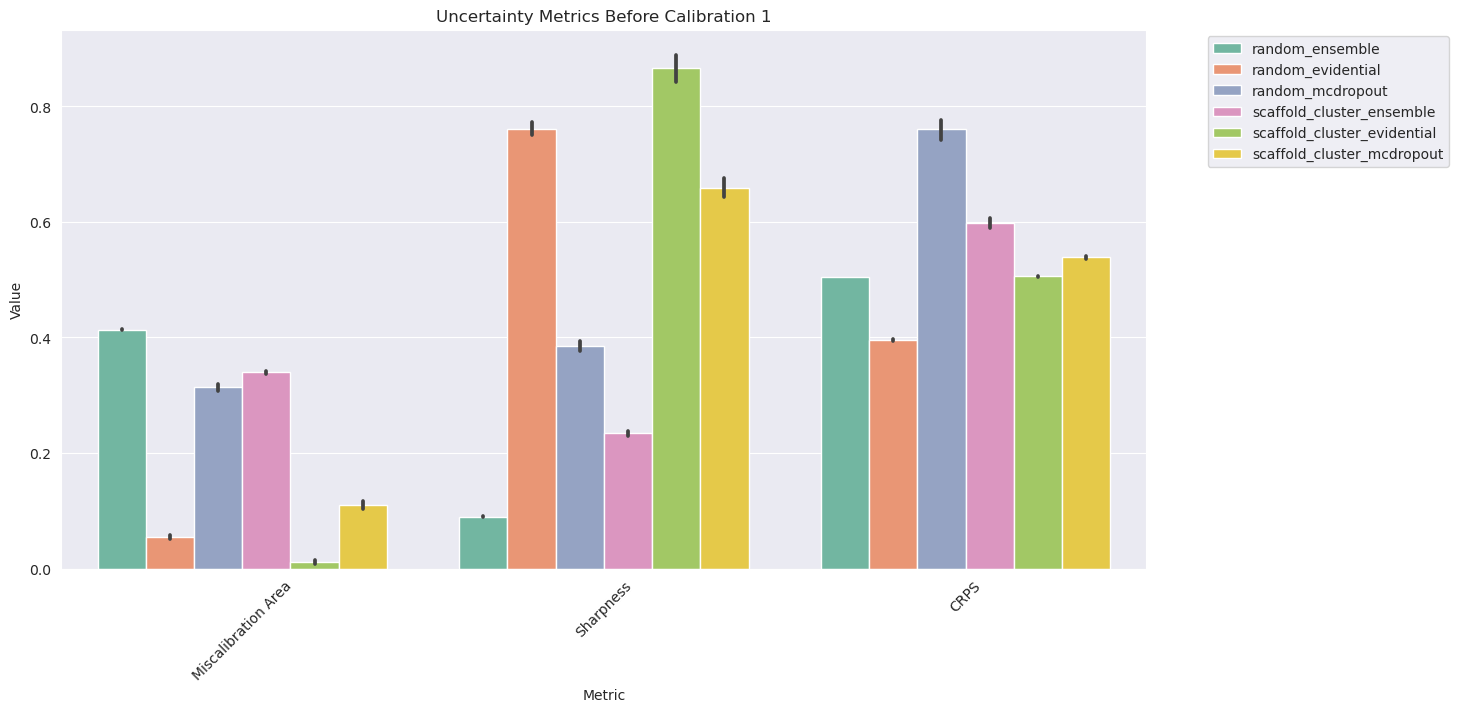

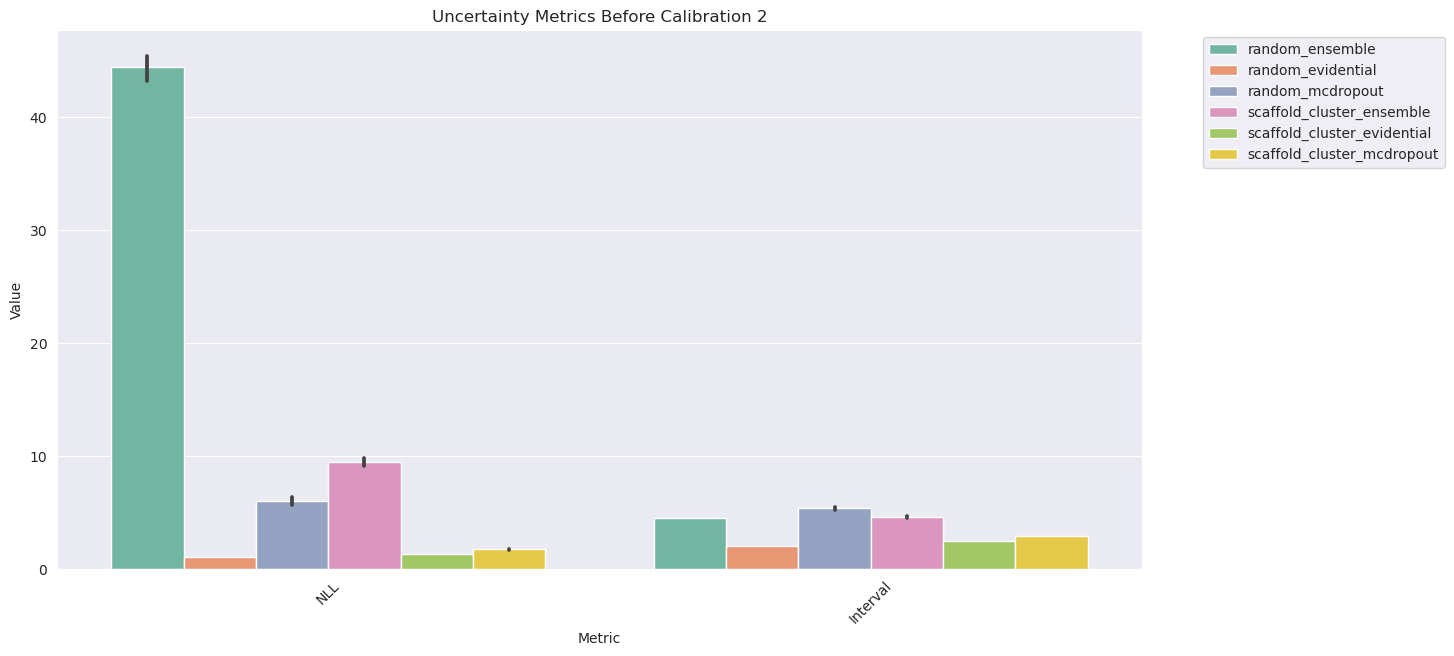

In [12]:
plot_metrics(df_before_calib, 'Uncertainty Metrics Before Calibration 1', uct_metrics_1, plot_type='bar', save_dir=save_dir)
plot_metrics(df_before_calib, 'Uncertainty Metrics Before Calibration 2', uct_metrics_2, plot_type='bar', save_dir=save_dir)


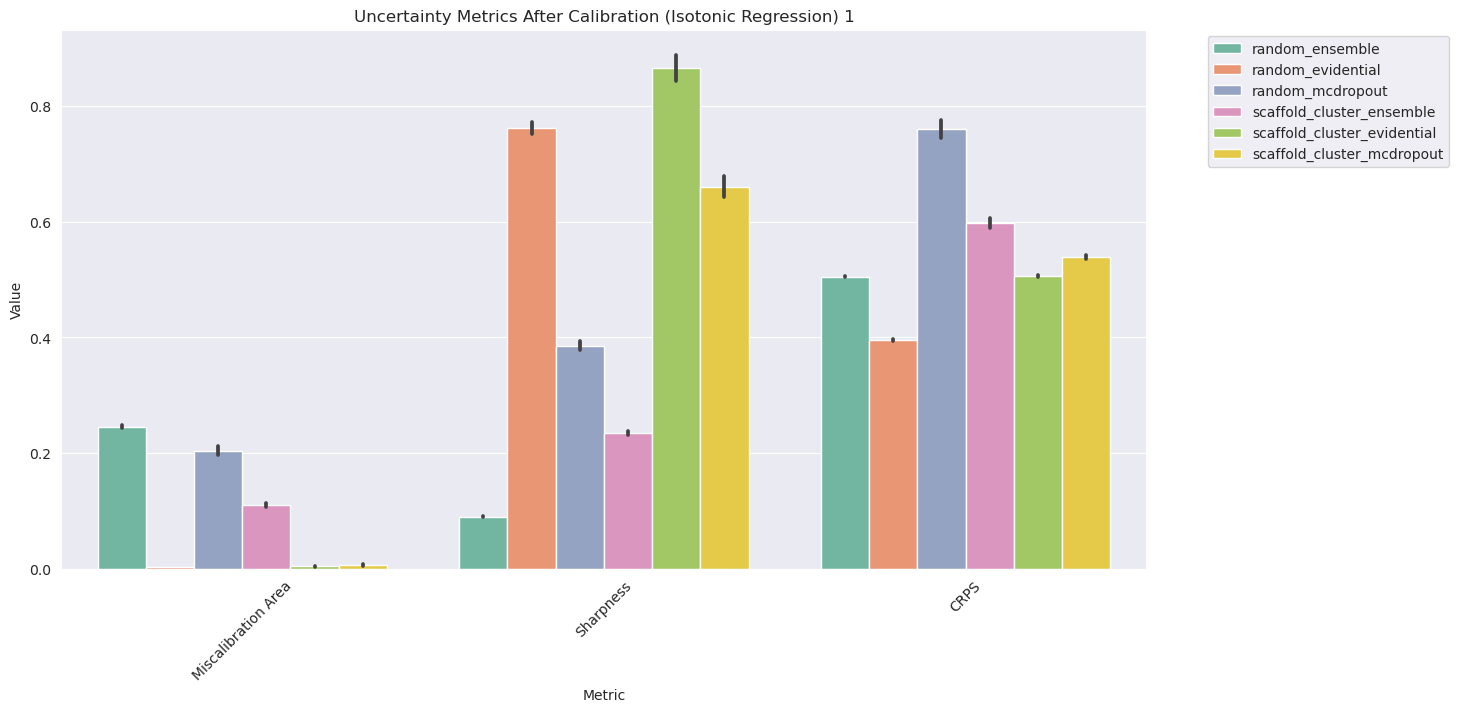

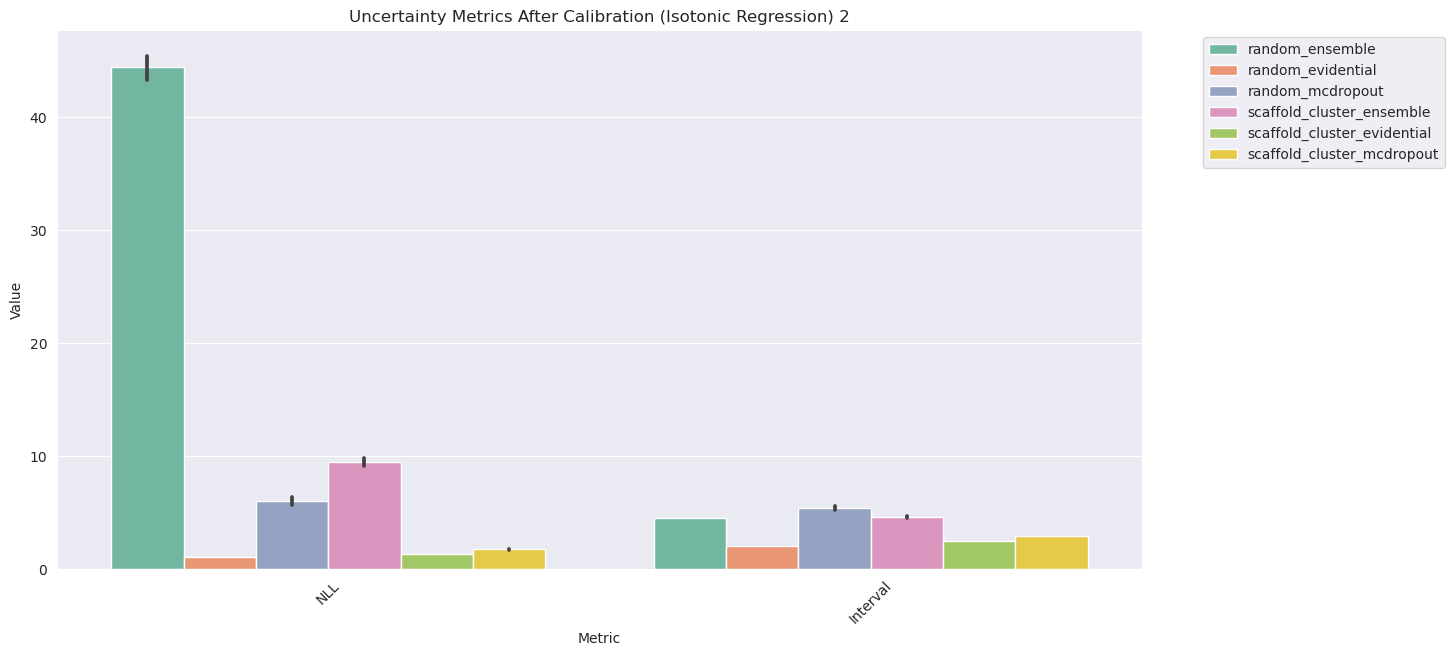

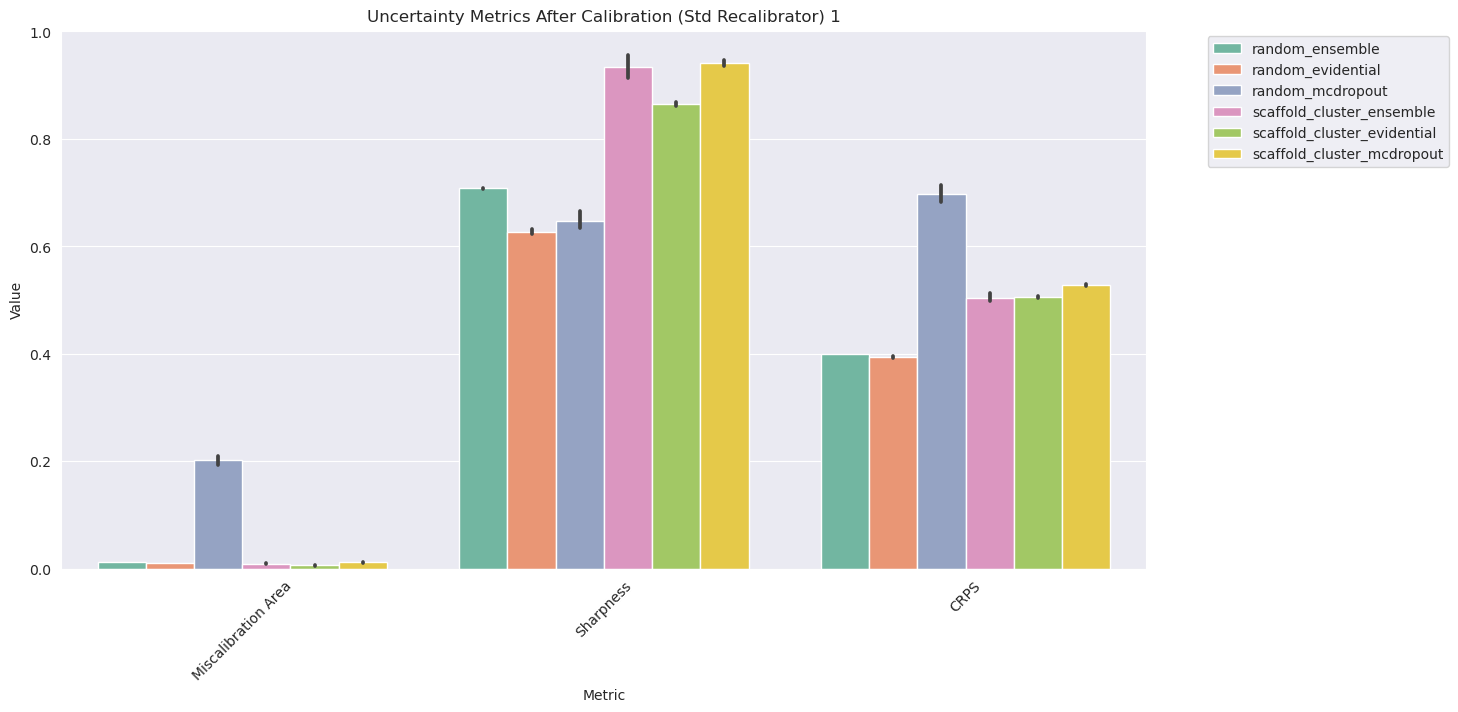

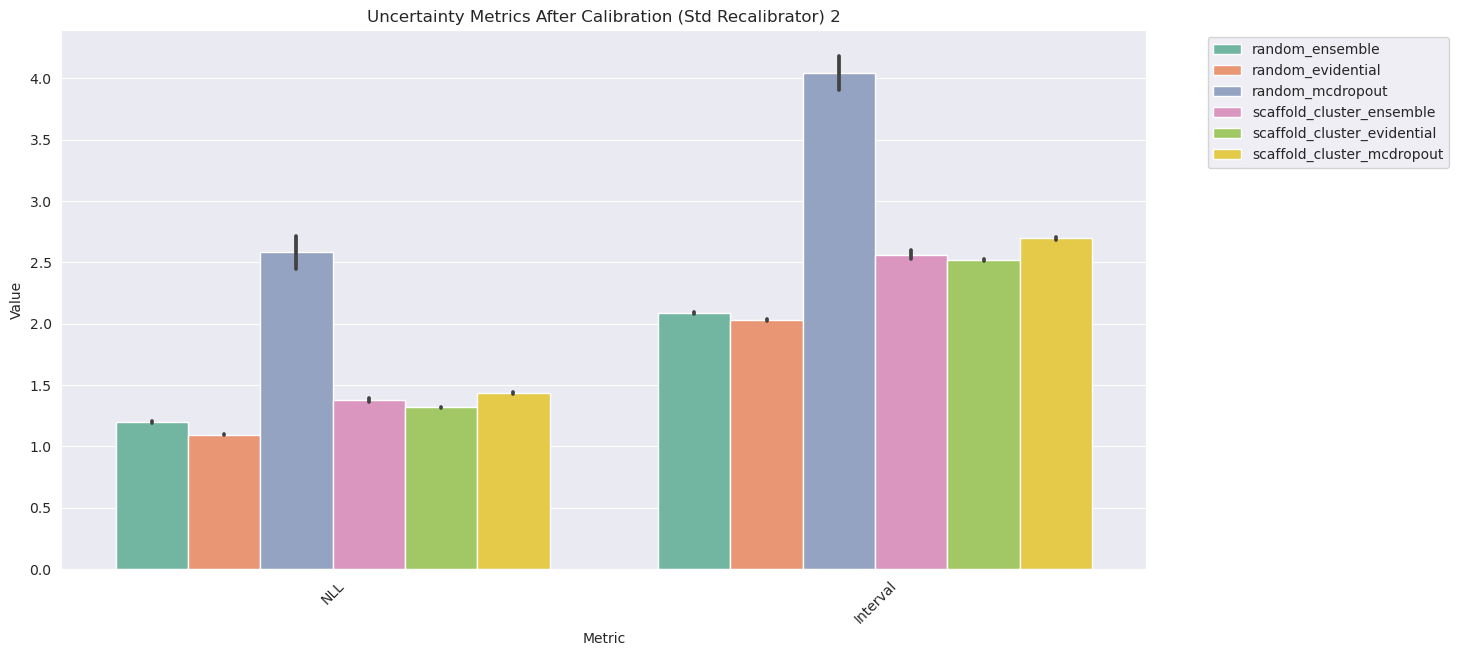

In [37]:
# AFter Isotonic Regression
plot_metrics(df_after_calib_iso, 'Uncertainty Metrics After Calibration (Isotonic Regression) 1', uct_metrics_1, plot_type='bar', save_dir=save_dir)
plot_metrics(df_after_calib_iso, 'Uncertainty Metrics After Calibration (Isotonic Regression) 2', uct_metrics_2, plot_type='bar', save_dir=save_dir)

# After Std Recalibrator
plot_metrics(df_after_calib_std, 'Uncertainty Metrics After Calibration (Std Recalibrator) 1', uct_metrics_1, plot_type='bar', save_dir=save_dir)
plot_metrics(df_after_calib_std, 'Uncertainty Metrics After Calibration (Std Recalibrator) 2', uct_metrics_2, plot_type='bar', save_dir=save_dir)


In [16]:
# Define custom colors and hatches for models and splits
model_colors = {
    'evidential': 'skyblue',
    'mcdropout': 'orange',
    'ensemble': 'green'
}

split_hatches = {
    'random': '.',
    'scaffold_cluster': '//'
}

# Function to plot metrics with split type grouping
def plot_metrics(df, title, metrics, plot_type='boxplot', save_dir=None):
    df = handle_inf_values(df)
    melted_df = df.melt(id_vars=['Group'], value_vars=metrics, var_name='Metric', value_name='Value')

    plt.figure(figsize=(14, 7))

    if plot_type in ['boxplot', 'violin', 'swarm', 'bar']:
        plot_func = {
            'boxplot': sns.boxplot,
            'violin': sns.violinplot,
            'swarm': sns.swarmplot,
            'bar': sns.barplot
        }[plot_type]

        ax = plot_func(data=melted_df, x='Metric', y='Value', hue='Group', palette=model_colors.values(), order=metrics, hue_order=group_order)

        for patch, group in zip(ax.patches, melted_df['Group'].unique()):
            print(patch, group)
            split = 'random' if 'random' in group else 'scaffold_cluster'
            model = 'evidential' if 'evidential' in group else ('mcdropout' if 'mcdropout' in group else 'ensemble')
            hatch = split_hatches[split]
            color = model_colors[model]
            print(split, model)
            print(color, hatch)

            patch.set_edgecolor(color)
            patch.set_facecolor(color)
            patch.set_hatch(hatch)


        # # Add textures to bars
        # for i, patch in enumerate(ax.patches):
        #     hatch = split_hatches['random' if 'random' in patch.get_label() else 'scaffold_cluster']
        #     patch.set_hatch(hatch)
        #     print(patch.get_label().split('_')[1])
        #     patch.set_edgecolor(model_colors[patch.get_label().split('_')[1]])
            # patch.set_edgecolor(model_colors[patch.get_label().split('_')[1]])

    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    plot_name = f"{plot_type}_{title.replace(' ', '_')}"
    save_plot(plt.gcf(), save_dir, plot_name)

# Function to plot metrics with split type grouping
# def plot_metrics(df, title, metrics, plot_type='boxplot', save_dir=None):
#     df = handle_inf_values(df)
#     melted_df = df.melt(id_vars=['Group'], value_vars=metrics, var_name='Metric', value_name='Value')
#     
#     plt.figure(figsize=(14, 7))
#     
#     if plot_type in ['boxplot', 'violin', 'swarm', 'bar']:
#         plot_func = {
#             'boxplot': sns.boxplot,
#             'violin': sns.violinplot,
#             'swarm': sns.swarmplot,
#             'bar': sns.barplot
#         }[plot_type]
# 
#         ax = plot_func(data=melted_df, x='Metric', y='Value', hue='Group', palette=list(model_colors.values()), order=metrics, hue_order=group_order)
# 
#         # Add textures to bars
#         for i, patch in enumerate(ax.patches):
#             group = melted_df['Group'].unique()[i // len(metrics)]
#             split = 'random' if 'random' in group else 'scaffold_cluster'
#             model = 'evidential' if 'evidential' in group else ('mcdropout' if 'mcdropout' in group else 'ensemble')
#             hatch = split_hatches[split]
#             color = model_colors[model]
#             
#             patch.set_edgecolor(color)
#             patch.set_facecolor(color)
#             patch.set_hatch(hatch)
# 
#     # Update legend to show both color and texture
#     handles, labels = ax.get_legend_handles_labels()
#     new_handles = []
#     new_labels = []
#     for handle, label in zip(handles, labels):
#         group = label
#         split = 'random' if 'random' in group else 'scaffold_cluster'
#         model = 'evidential' if 'evidential' in group else ('mcdropout' if 'mcdropout' in group else 'ensemble')
#         hatch = split_hatches[split]
#         color = model_colors[model]
#         patch = plt.Rectangle((0, 0), 1, 1, fc=color, hatch=hatch)
#         new_handles.append(patch)
#         new_labels.append(f"{model} ({split})")
#     
#     plt.legend(new_handles, new_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.title(title)
#     plt.xticks(rotation=45)
#     plt.show()
# 
#     plot_name = f"{plot_type}_{title.replace(' ', '_')}"
#     save_plot(plt.gcf(), save_dir, plot_name)


Rectangle(xy=(-0.4, 0), width=0.133333, height=0.727491, angle=0) random_evidential
random evidential
skyblue .
Rectangle(xy=(0.6, 0), width=0.133333, height=0.636425, angle=0) random_mcdropout
random mcdropout
orange .
Rectangle(xy=(1.6, 0), width=0.133333, height=0.547891, angle=0) scaffold_cluster_mcdropout
scaffold_cluster mcdropout
orange //
Rectangle(xy=(2.6, 0), width=0.133333, height=0.426635, angle=0) scaffold_cluster_evidential
scaffold_cluster evidential
skyblue //
Rectangle(xy=(3.6, 0), width=0.133333, height=0.798714, angle=0) random_ensemble
random ensemble
green .
Rectangle(xy=(-0.266667, 0), width=0.133333, height=0.72828, angle=0) scaffold_cluster_ensemble
scaffold_cluster ensemble
green //


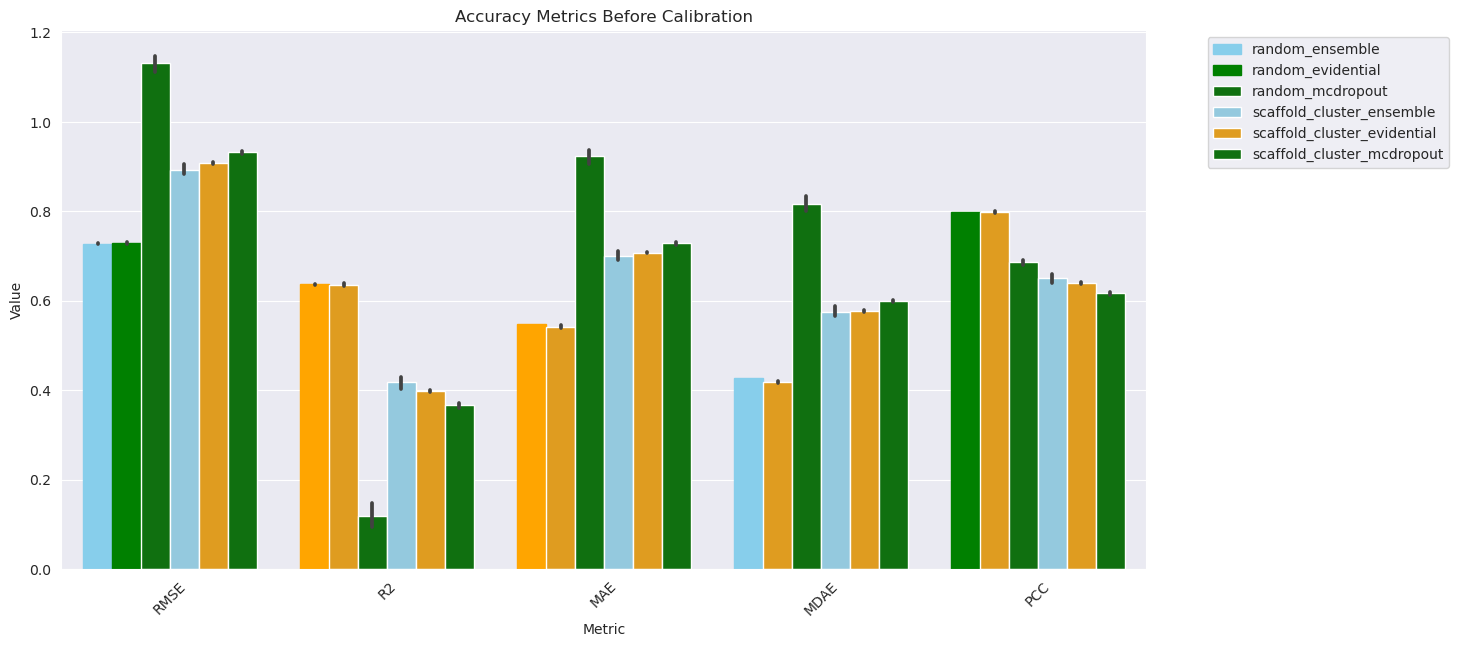

<Figure size 640x480 with 0 Axes>

In [17]:
plot_metrics(df_before_calib, 'Accuracy Metrics Before Calibration', acc_metrics, plot_type='bar', save_dir=None)

|# Comparing Calibration Metrics Before and After Calibration in one plot

In [13]:
def plot_bar_uncertainty_metric_comparison(df, title, metric, plot_type="bar", group_order=group_order, save_dir=None):
    df = handle_inf_values(df)
    melted_df = df.melt(id_vars=['Group', 'Calibration'], value_vars=[metric], var_name='Metric', value_name='Value')
    plt.figure(figsize=(14, 7))
    if plot_type == 'bar':
        sns.barplot(data=melted_df, x='Group', y='Value', hue='Calibration', palette="Set2", errorbar='sd', dodge=True, order=group_order)
    elif plot_type == 'violin':
        sns.violinplot(data=melted_df, x='Group', y='Value', hue='Calibration', palette="Set2", inner="quart", dodge=True, order=group_order)
    elif plot_type == 'swarm':
        sns.swarmplot(data=melted_df, x='Group', y='Value', hue='Calibration', palette="Set2", dodge=True, order=group_order)
    sns.despine()
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plot_name = f"bar_{title.replace(' ', '_')}"
    save_plot(plt.gcf(), save_dir, plot_name)
    plt.show()

In [14]:
# Add a column to indicate calibration state
df_before_calib['Calibration'] = 'Before Calibration'
df_after_calib_iso['Calibration'] = 'After Isotonic Regression'
df_after_calib_std['Calibration'] = 'After Std Recalibrator'

# Combine all data into one DataFrame
df_combined = pd.concat([df_before_calib, df_after_calib_iso, df_after_calib_std])

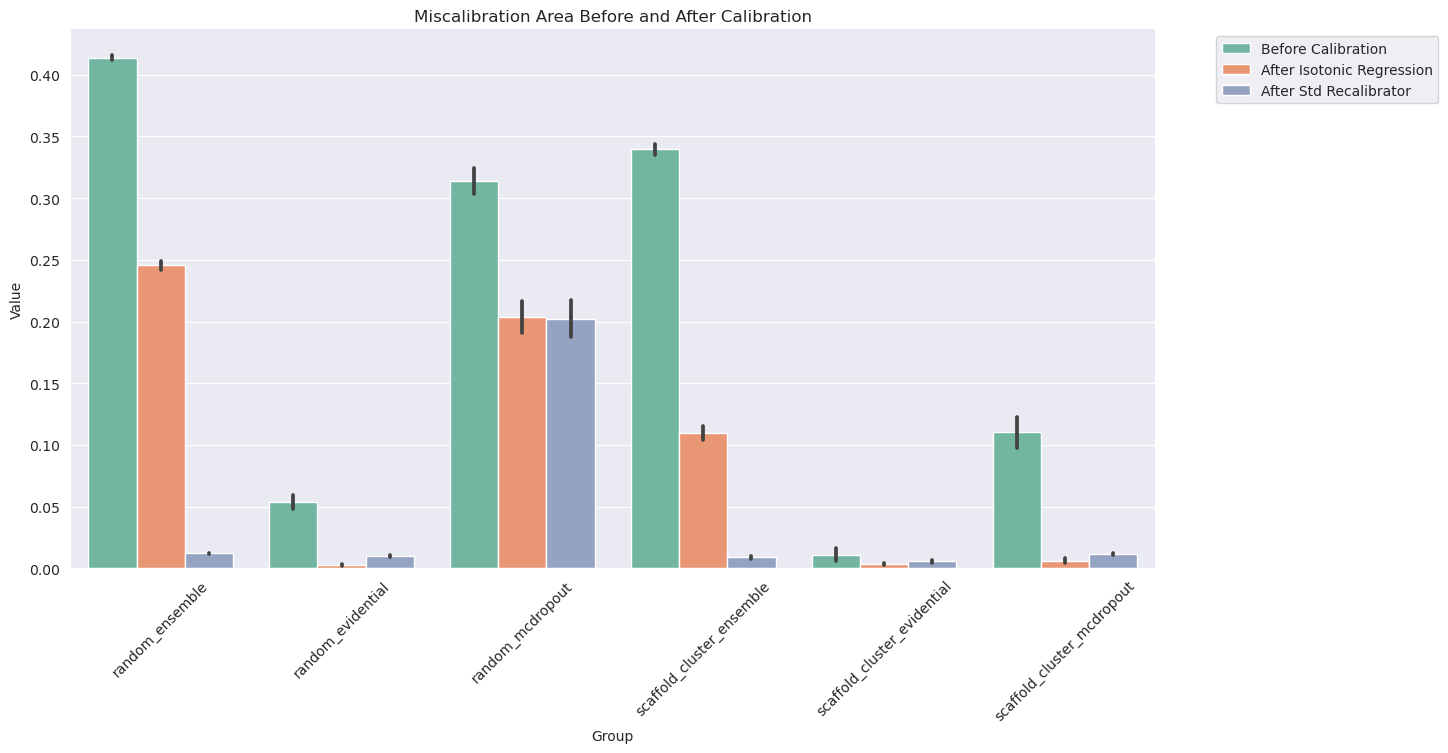

In [50]:
plot_bar_uncertainty_metric_comparison(df_combined, 'Miscalibration Area Before and After Calibration', 'Miscalibration Area', save_dir=save_dir)

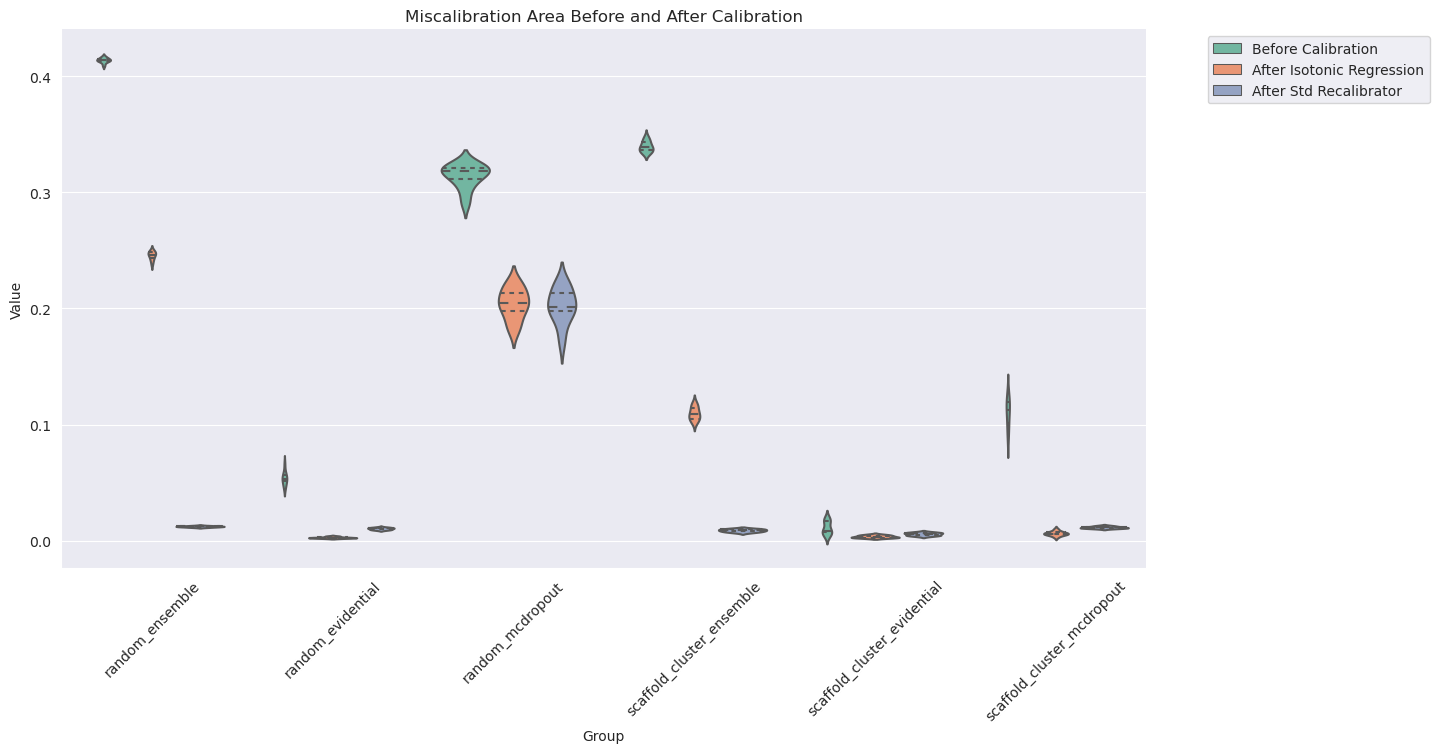

In [15]:
plot_bar_uncertainty_metric_comparison(df_combined, 'Miscalibration Area Before and After Calibration', 'Miscalibration Area', save_dir=save_dir, plot_type="violin")

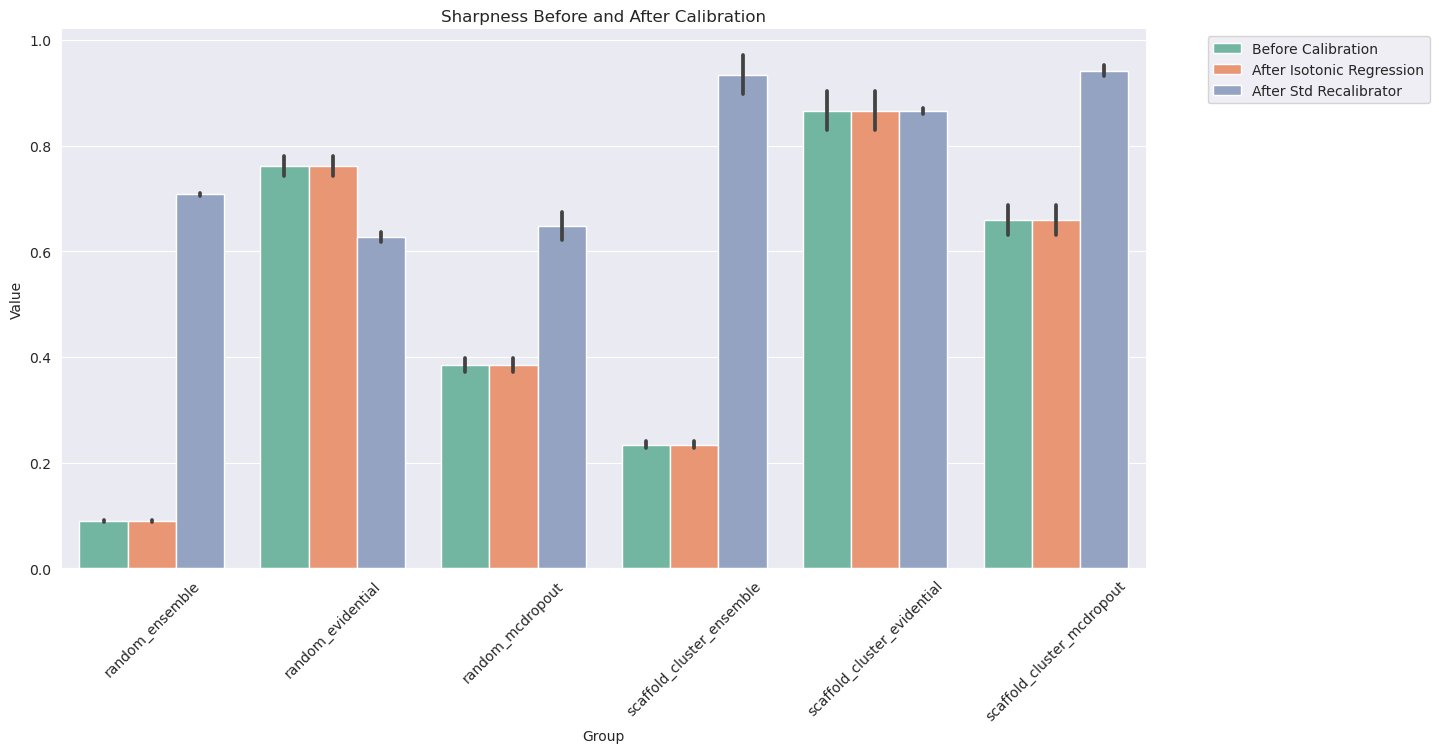

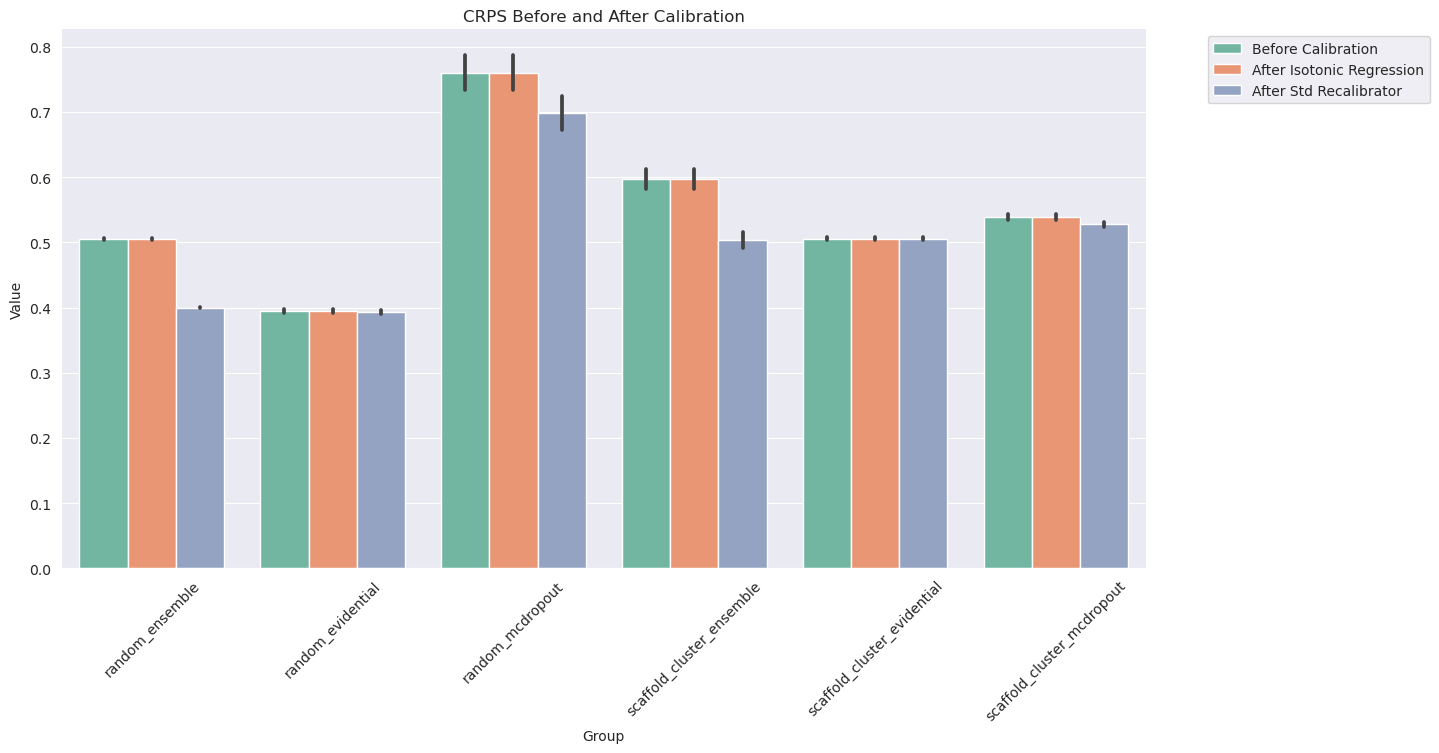

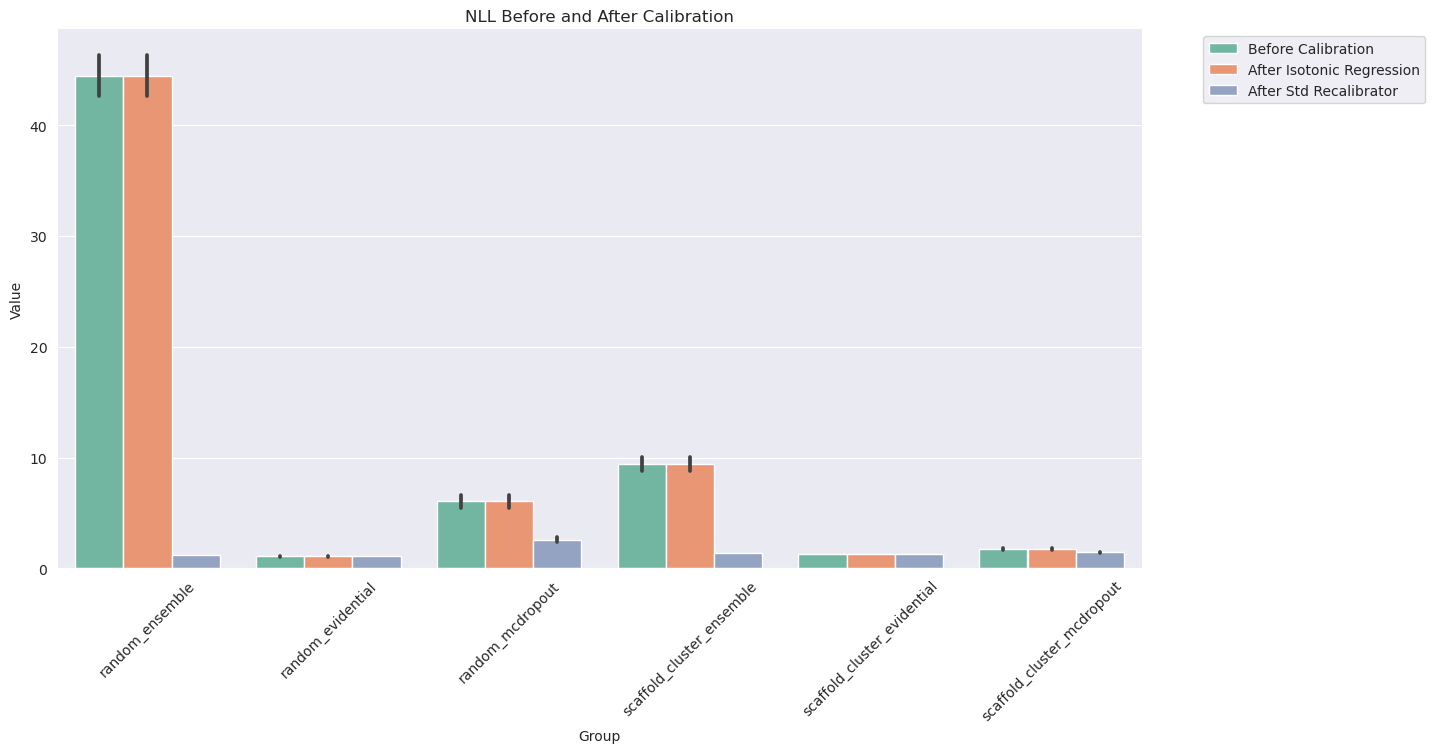

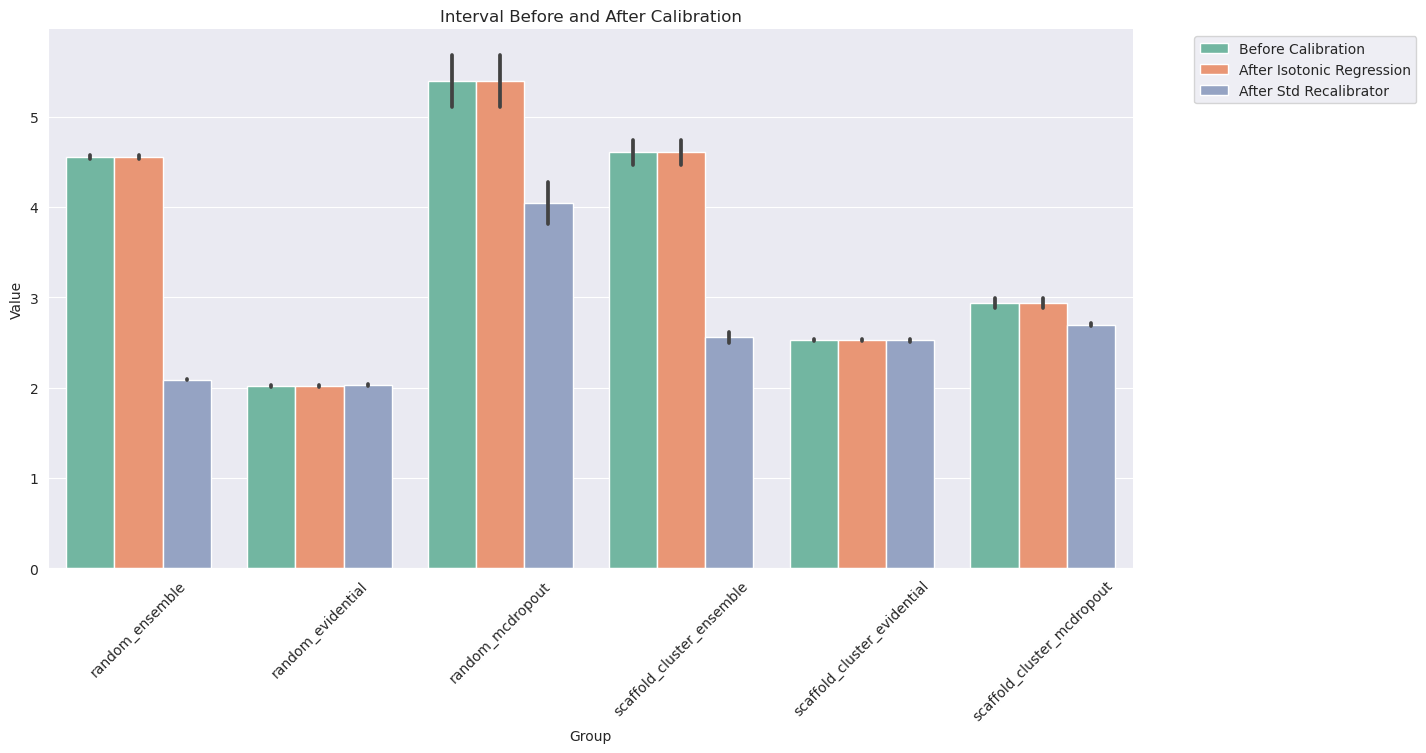

In [56]:
# other metrics before and after
plot_bar_uncertainty_metric_comparison(df_combined, 'Sharpness Before and After Calibration', 'Sharpness', save_dir=save_dir)
plot_bar_uncertainty_metric_comparison(df_combined, 'CRPS Before and After Calibration', 'CRPS', save_dir=save_dir)
plot_bar_uncertainty_metric_comparison(df_combined, 'NLL Before and After Calibration', 'NLL', save_dir=save_dir)
plot_bar_uncertainty_metric_comparison(df_combined, 'Interval Before and After Calibration', 'Interval', save_dir=save_dir)

# Special MC Dropout Experiment

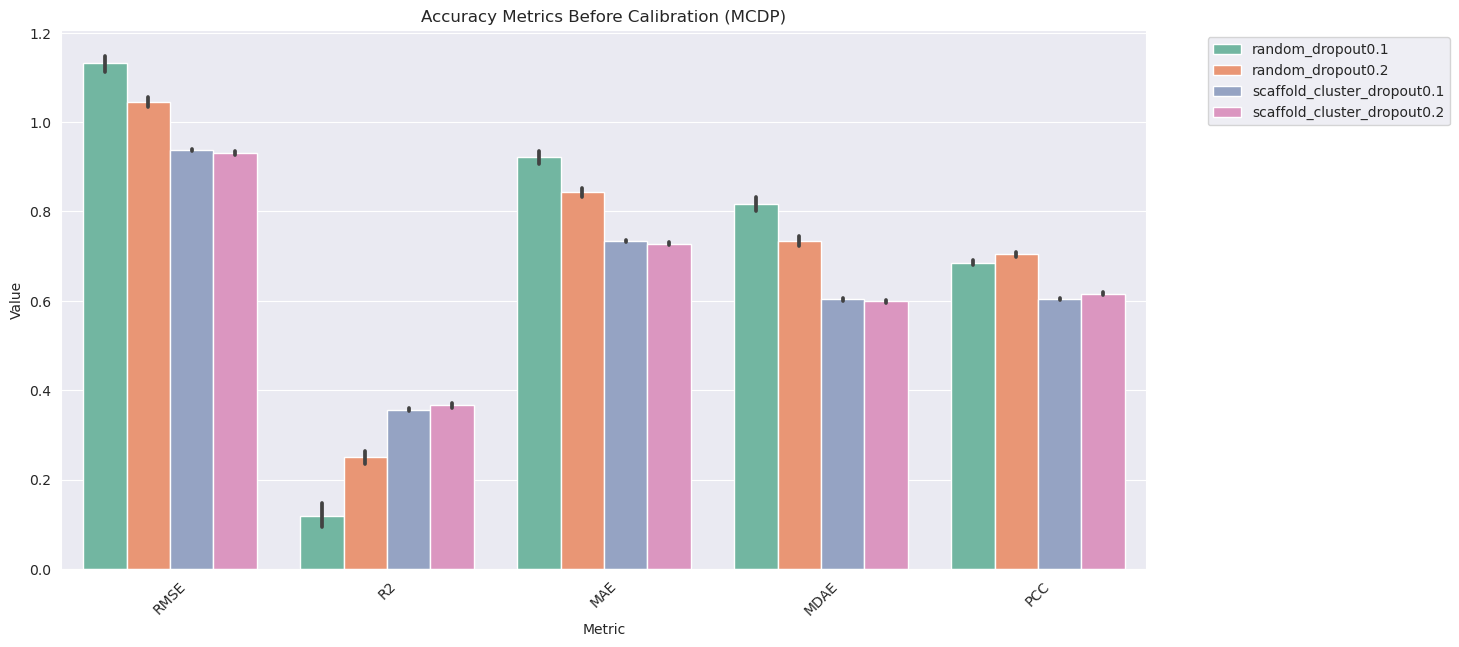

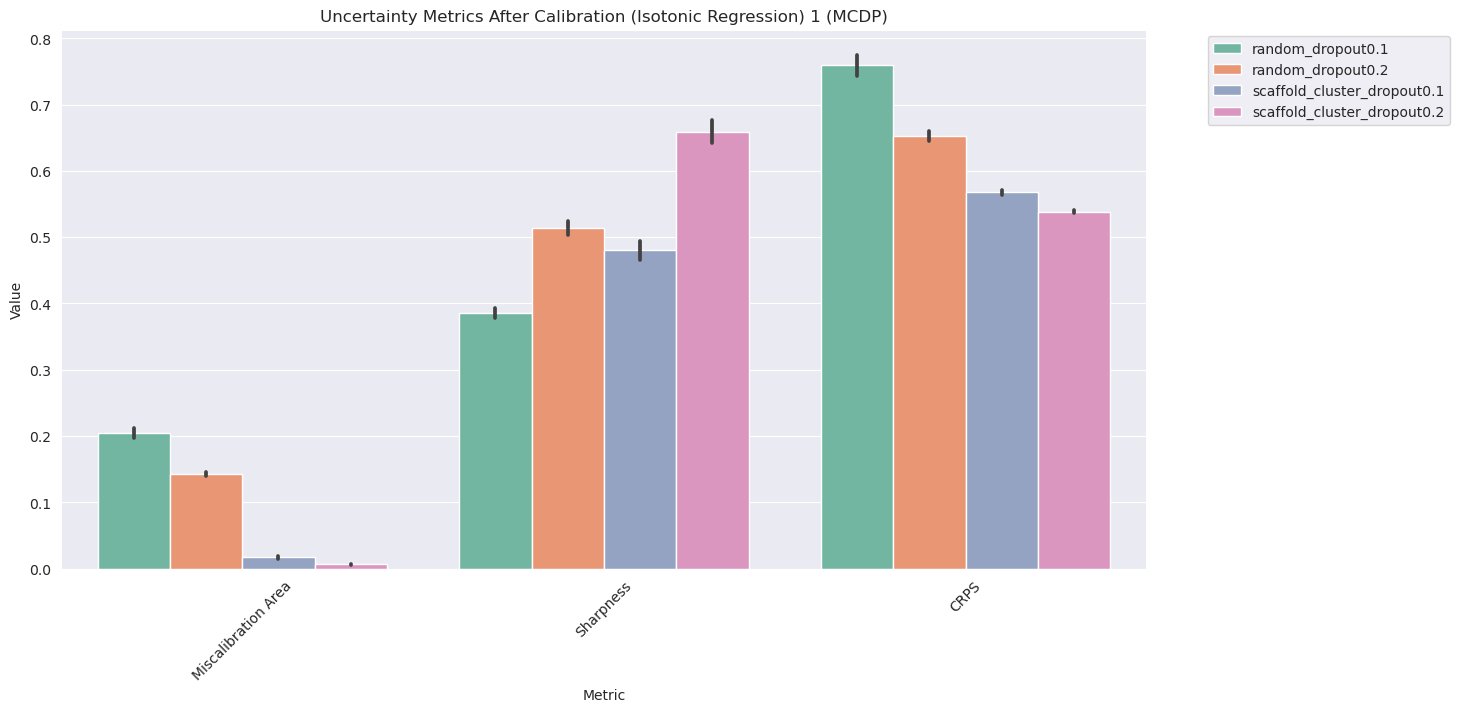

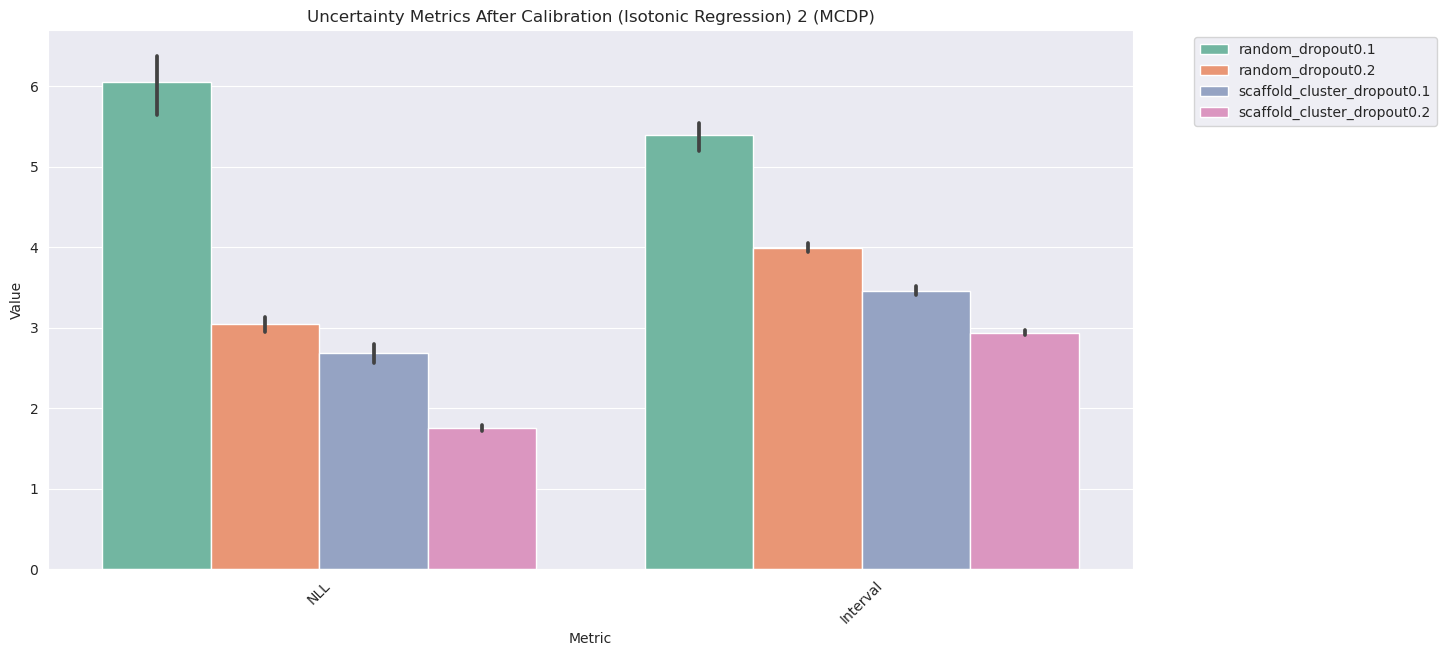

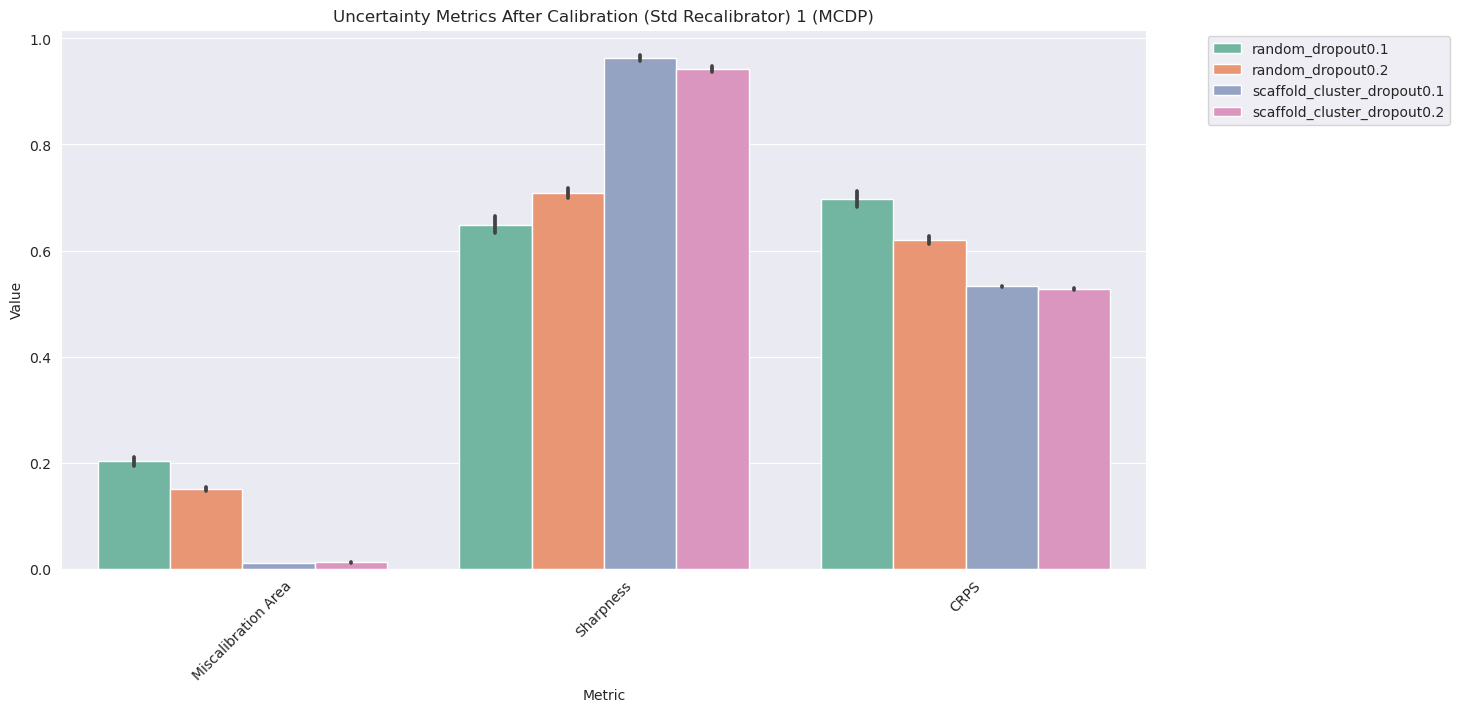

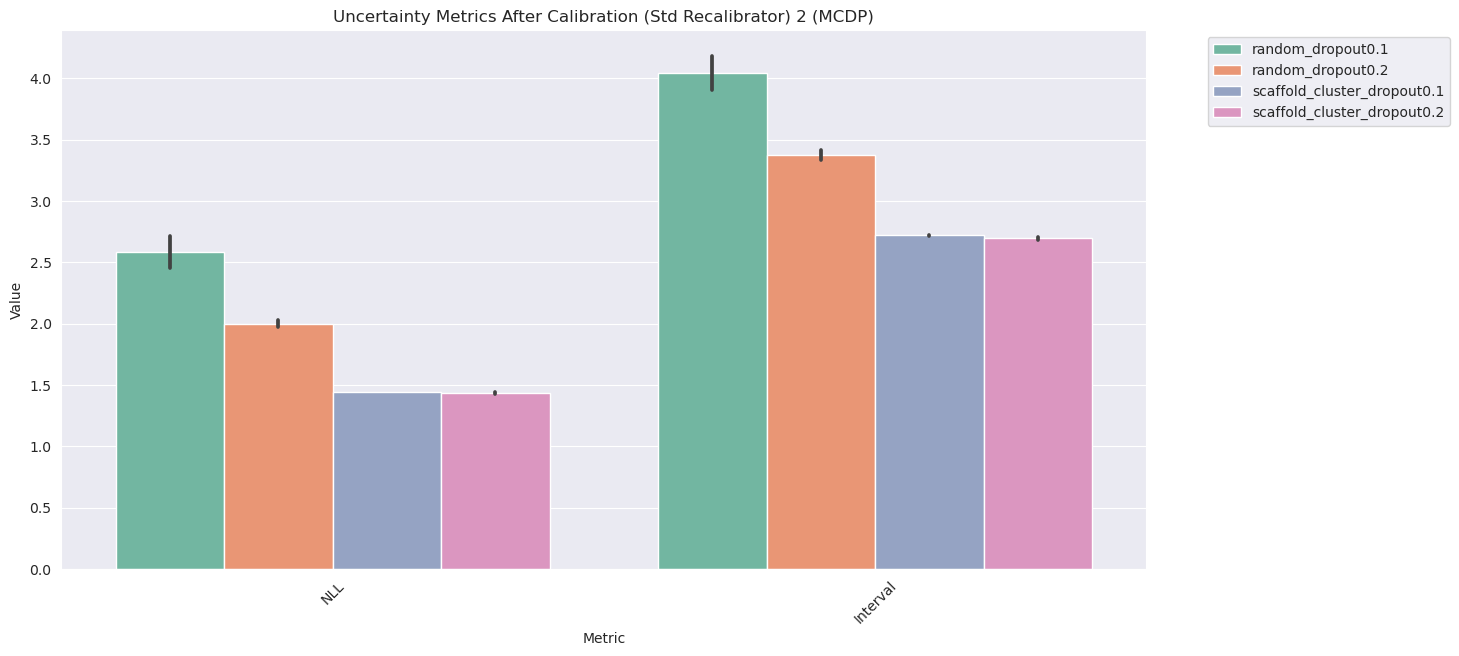

In [53]:
# Now we shall plot the same but to compare the MCDP results
plot_metrics(mcdp_before_calib, 'Accuracy Metrics Before Calibration (MCDP)', acc_metrics, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)
plot_metrics(mcdp_after_calib_iso, 'Uncertainty Metrics After Calibration (Isotonic Regression) 1 (MCDP)', uct_metrics_1, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)
plot_metrics(mcdp_after_calib_iso, 'Uncertainty Metrics After Calibration (Isotonic Regression) 2 (MCDP)', uct_metrics_2, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)
plot_metrics(mcdp_after_calib_std, 'Uncertainty Metrics After Calibration (Std Recalibrator) 1 (MCDP)', uct_metrics_1, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)
plot_metrics(mcdp_after_calib_std, 'Uncertainty Metrics After Calibration (Std Recalibrator) 2 (MCDP)', uct_metrics_2, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)

/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning

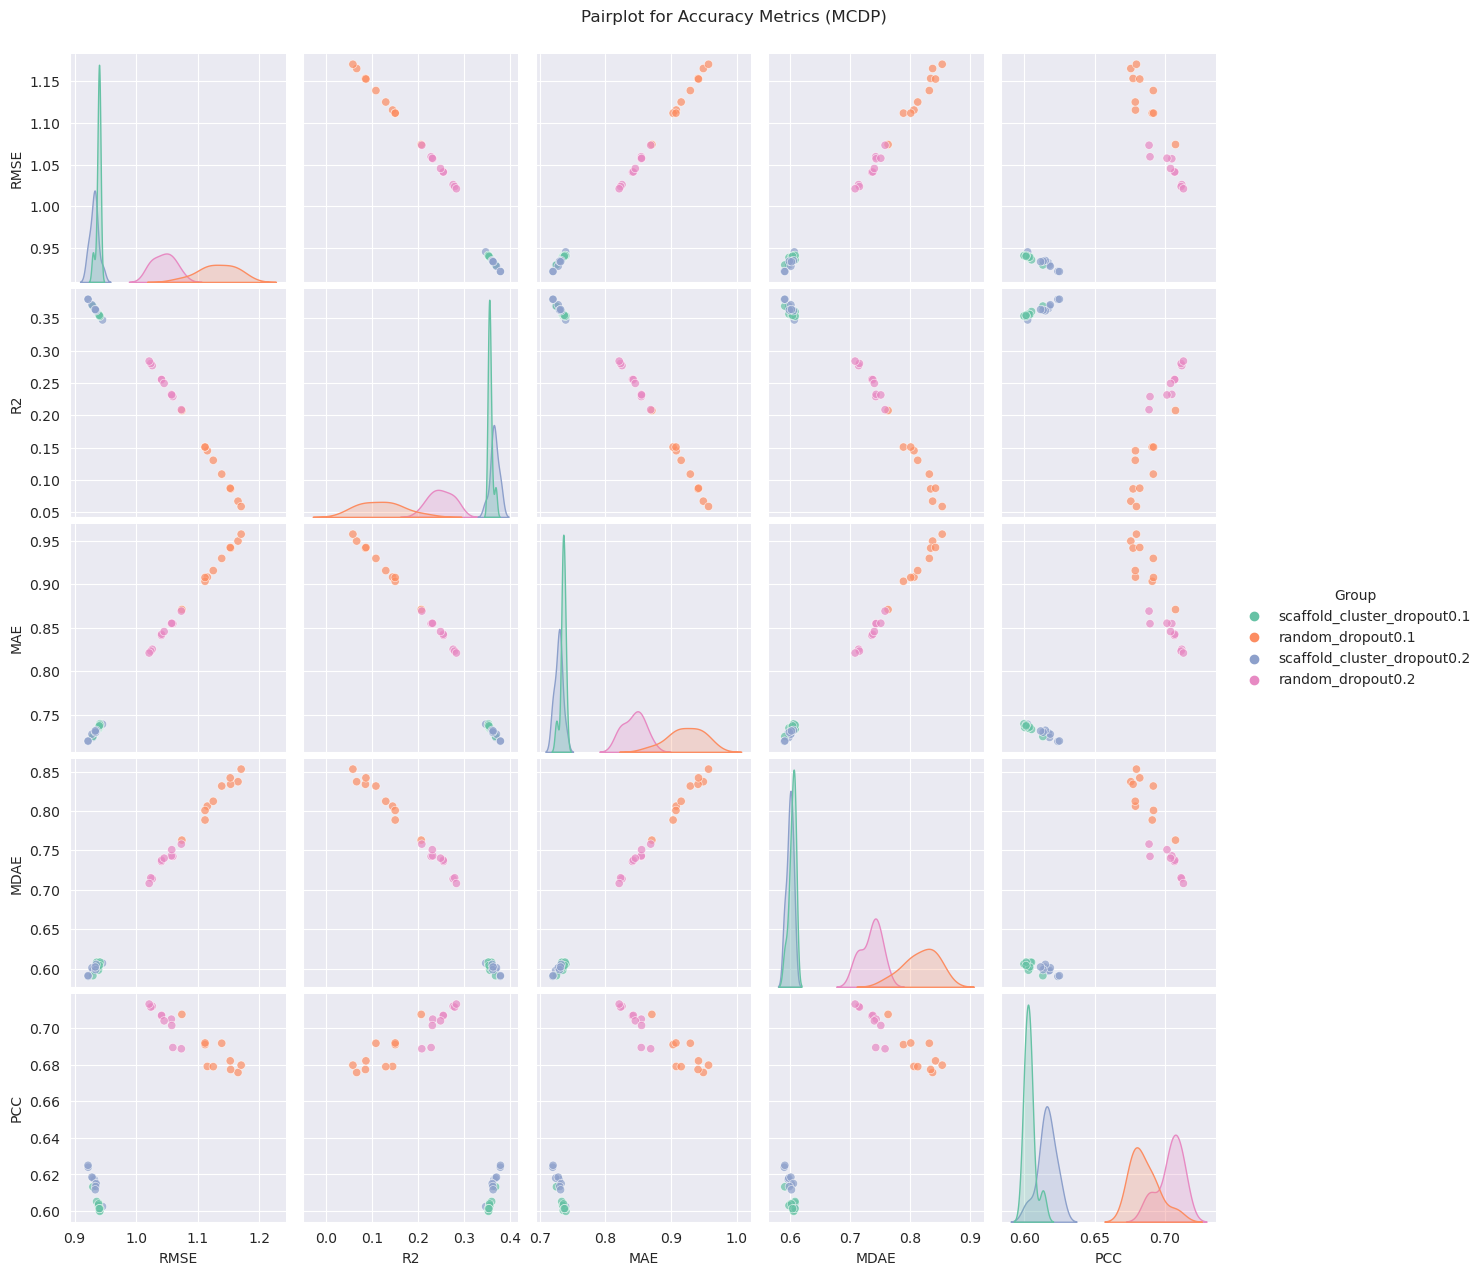

/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bkhalil/miniconda3/envs/uqdd-biotrans/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning

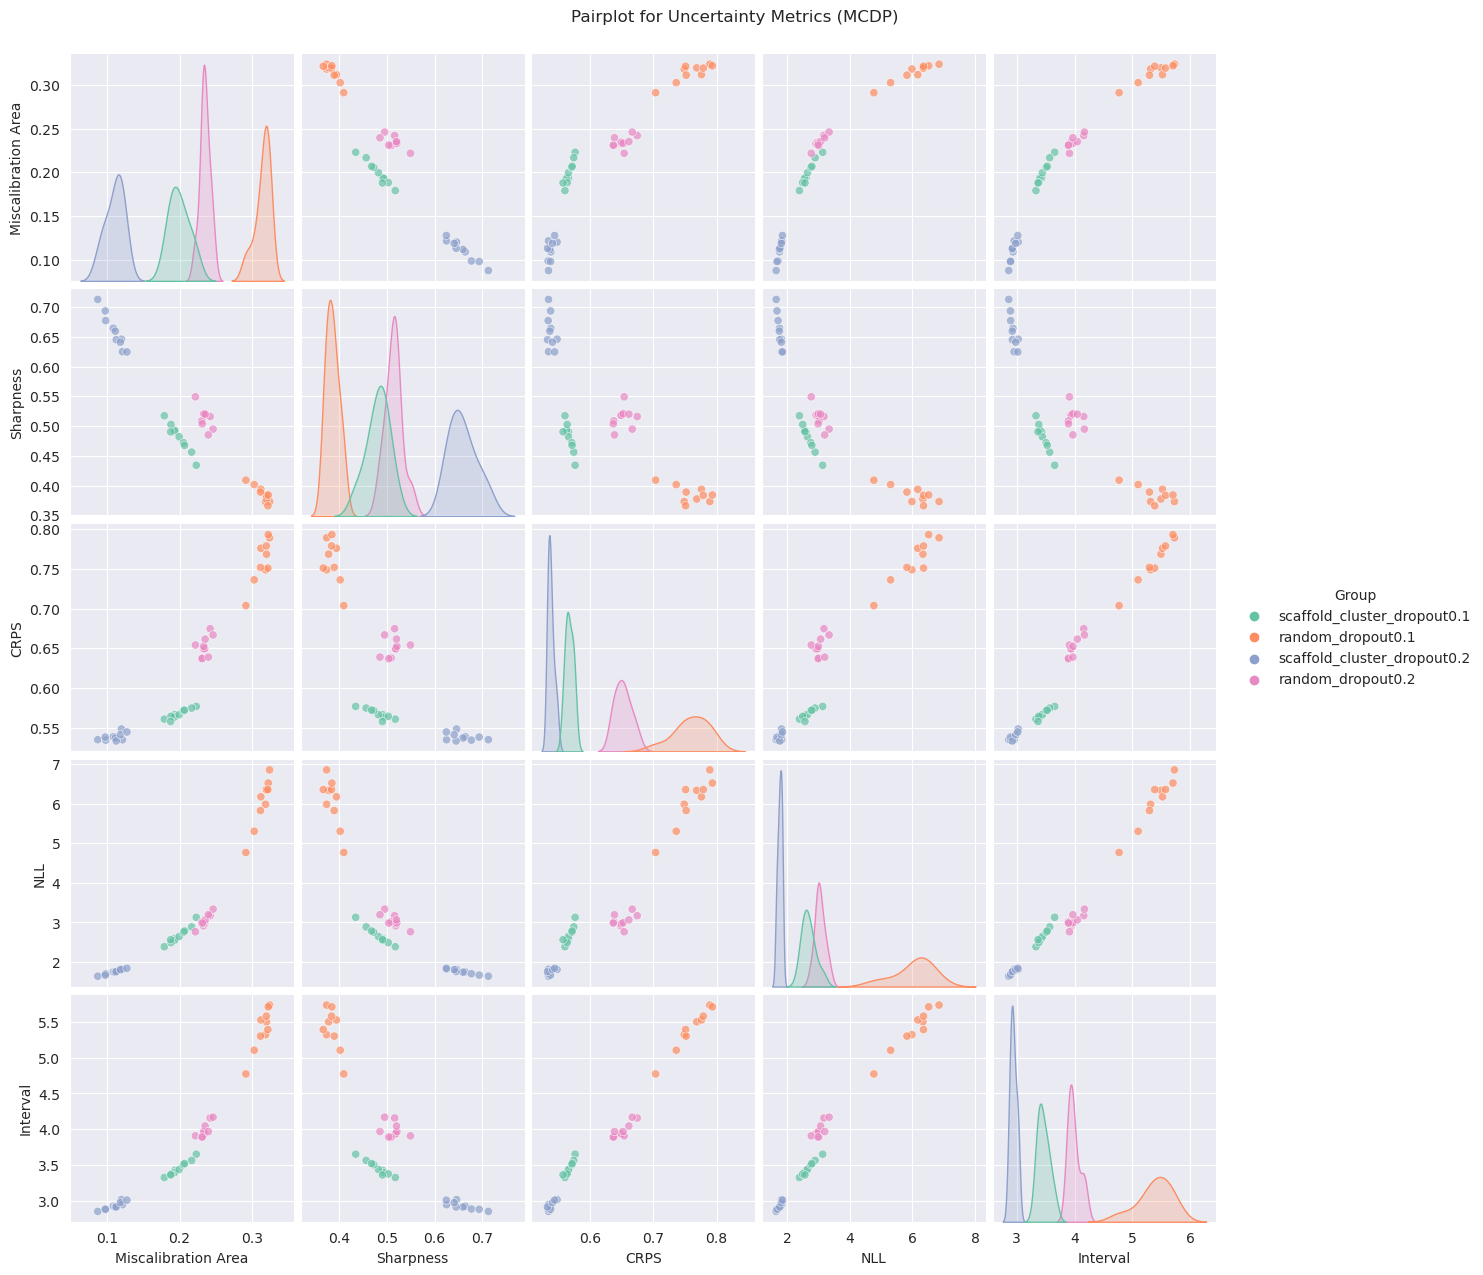

In [54]:
# Pair plot
plot_pairplot(mcdp_before_calib, 'Pairplot for Accuracy Metrics (MCDP)', acc_metrics, save_dir=save_dir)

# Pair plot for Uncertainty Metrics
plot_pairplot(mcdp_before_calib, 'Pairplot for Uncertainty Metrics (MCDP)', uct_metrics_1+uct_metrics_2, save_dir=save_dir)

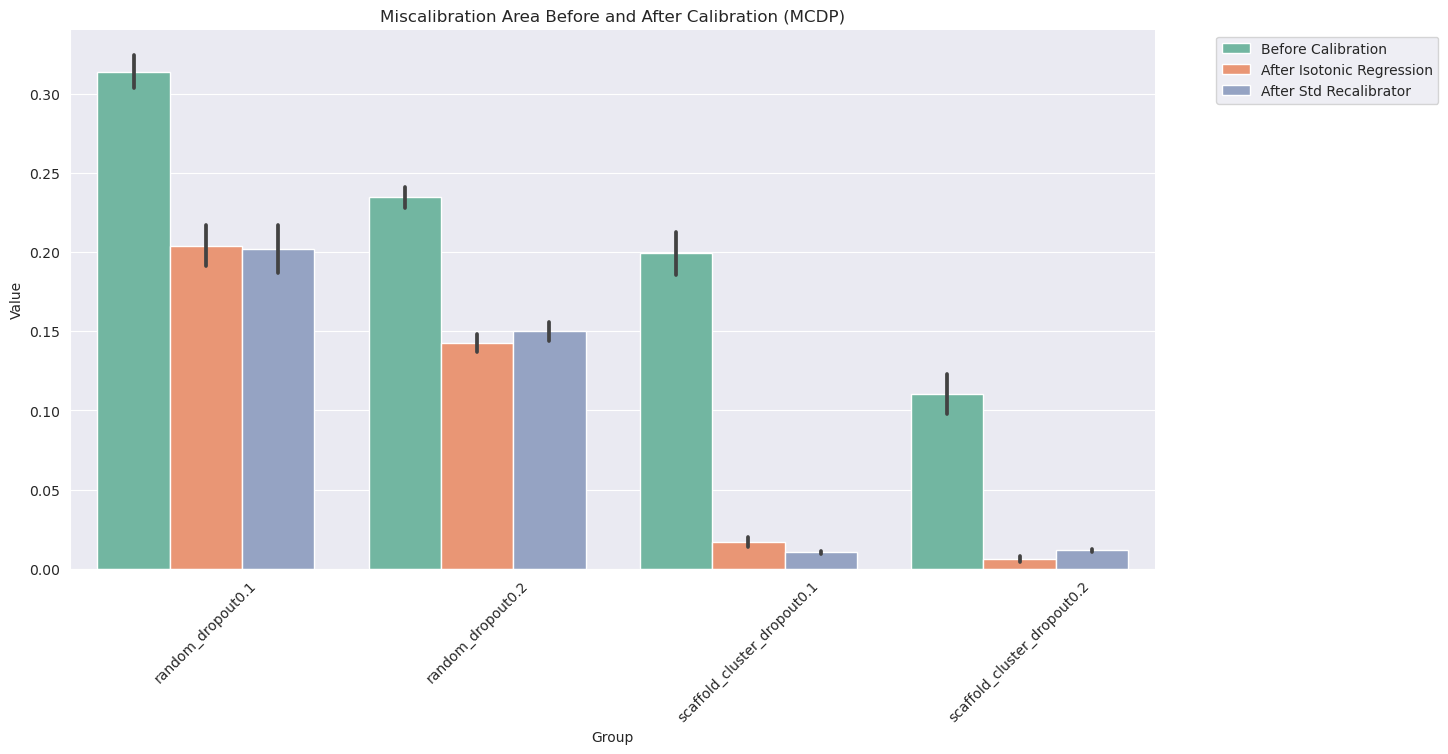

In [55]:
# Comparing Calibration Metrics Before and After Calibration in one plot
# Add a column to indicate calibration state
mcdp_before_calib['Calibration'] = 'Before Calibration'
mcdp_after_calib_iso['Calibration'] = 'After Isotonic Regression'
mcdp_after_calib_std['Calibration'] = 'After Std Recalibrator'

# Combine all data into one DataFrame
mcdp_combined = pd.concat([mcdp_before_calib, mcdp_after_calib_iso, mcdp_after_calib_std])

plot_bar_uncertainty_metric_comparison(mcdp_combined, 'Miscalibration Area Before and After Calibration (MCDP)', 'Miscalibration Area', save_dir=save_dir, group_order=mc_group_order)
